In [1]:
library(tidyverse)
library(emmeans)
library(cowplot)
library(car)
library(olsrr)
library(lmtest)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
df_eff <- read_csv('effervescence.csv', col_types = 'fffnnn')
df_eff %>% head()
df_eff %>% summary()
df_eff %>% str()

Brand,Temp,Stirred,Order,Time
<fct>,<fct>,<fct>,<dbl>,<dbl>
name,6,yes,8,77.21547
name,23,yes,3,75.37855
name,40,yes,7,68.08492
store,6,yes,1,77.87371
store,23,yes,2,66.38436
store,40,yes,18,59.82388


   Brand    Temp    Stirred      Order            Time      
 name :24   6 :16   yes:24   Min.   : 1.00   Min.   :58.24  
 store:24   23:16   no :24   1st Qu.:12.75   1st Qu.:66.09  
            40:16            Median :24.50   Median :70.92  
                             Mean   :24.50   Mean   :70.77  
                             3rd Qu.:36.25   3rd Qu.:76.93  
                             Max.   :48.00   Max.   :80.92  

spec_tbl_df [48 × 5] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Brand  : Factor w/ 2 levels "name","store": 1 1 1 2 2 2 1 1 1 2 ...
 $ Temp   : Factor w/ 3 levels "6","23","40": 1 2 3 1 2 3 1 2 3 1 ...
 $ Stirred: Factor w/ 2 levels "yes","no": 1 1 1 1 1 1 1 1 1 1 ...
 $ Order  : num [1:48] 8 3 7 1 2 18 9 4 10 12 ...
 $ Time   : num [1:48] 77.2 75.4 68.1 77.9 66.4 ...
 - attr(*, "spec")=
  .. cols(
  ..   Brand = col_factor(levels = NULL, ordered = FALSE, include_na = FALSE),
  ..   Temp = col_factor(levels = NULL, ordered = FALSE, include_na = FALSE),
  ..   Stirred = col_factor(levels = NULL, ordered = FALSE, include_na = FALSE),
  ..   Order = col_number(),
  ..   Time = col_number()
  .. )
 - attr(*, "problems")=<externalptr> 


### Description of data
In this data set, we have 48 rows and 6 columns. The 6 columns include 3 explanatory variables (Brand, Temp, Stirred categorical factors), 2 response variables (Time and Org Time, both numerical) and 1 descriptor (sample order).  

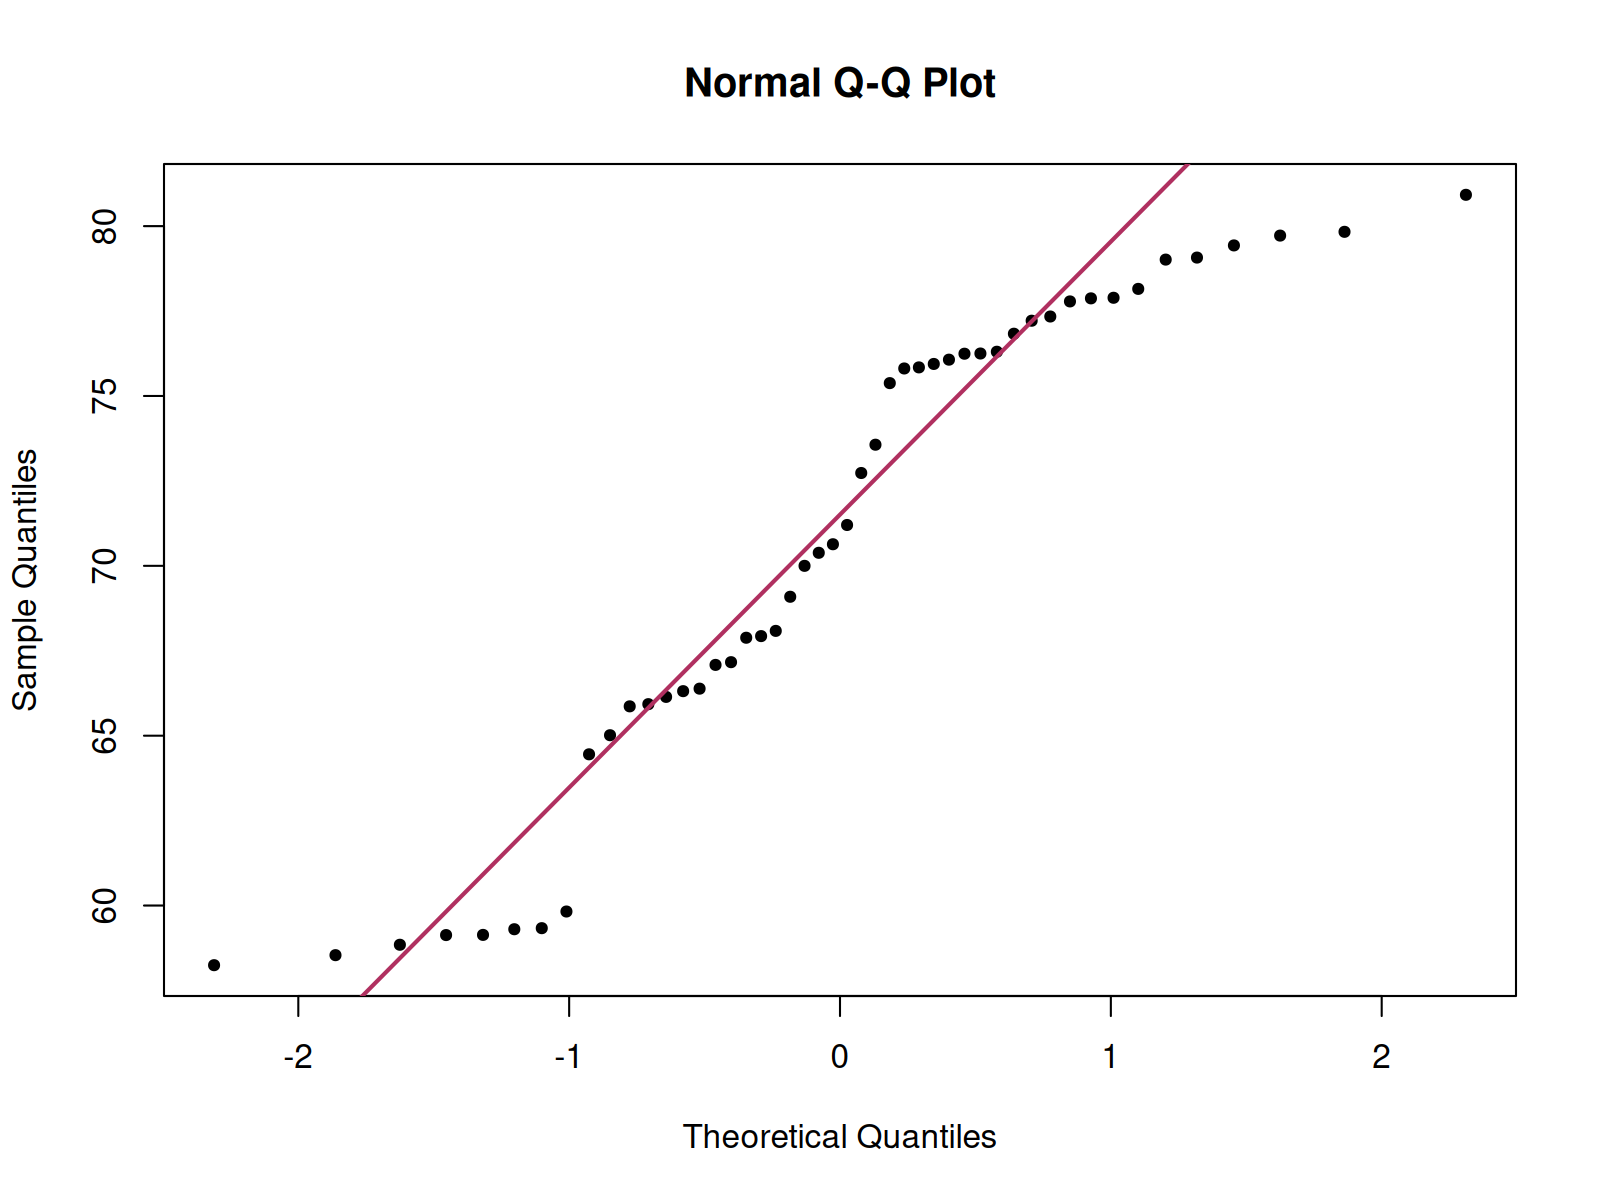

In [3]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
qqnorm(df_eff$Time, pch = 20)
qqline(df_eff$Time, col = "maroon", lwd = 2)

### Normality of the Data

A number of analyses assume that the data in question follows a normal distribution. To check for this a QQ plot is created and as can be seen there is some deviation from normality. To confirm this a Shapiro Wilk Test is conducted:

In [4]:
shapiro.test(df_eff$Time)


	Shapiro-Wilk normality test

data:  df_eff$Time
W = 0.90967, p-value = 0.00131


The low p value indicates that the data is not normal. 

In [5]:
df1 <- df_eff %>% filter(Temp == '6')
shapiro.test(df1$Time)

df2 <- df_eff %>% filter(Temp == '23')
shapiro.test(df2$Time)

df3 <- df_eff %>% filter(Temp == '40')
shapiro.test(df3$Time)

df4 <- df_eff %>% filter(Brand == 'store')
shapiro.test(df4$Time)

df5 <- df_eff %>% filter(Brand == 'name')
shapiro.test(df5$Time)

df6 <- df_eff %>% filter(Stirred == 'no')
shapiro.test(df6$Time)

df7 <- df_eff %>% filter(Stirred == 'yes')
shapiro.test(df7$Time)


	Shapiro-Wilk normality test

data:  df1$Time
W = 0.94934, p-value = 0.4793



	Shapiro-Wilk normality test

data:  df2$Time
W = 0.82266, p-value = 0.005535



	Shapiro-Wilk normality test

data:  df3$Time
W = 0.82444, p-value = 0.00586



	Shapiro-Wilk normality test

data:  df4$Time
W = 0.86044, p-value = 0.003437



	Shapiro-Wilk normality test

data:  df5$Time
W = 0.92172, p-value = 0.06377



	Shapiro-Wilk normality test

data:  df6$Time
W = 0.87798, p-value = 0.007569



	Shapiro-Wilk normality test

data:  df7$Time
W = 0.89458, p-value = 0.01655


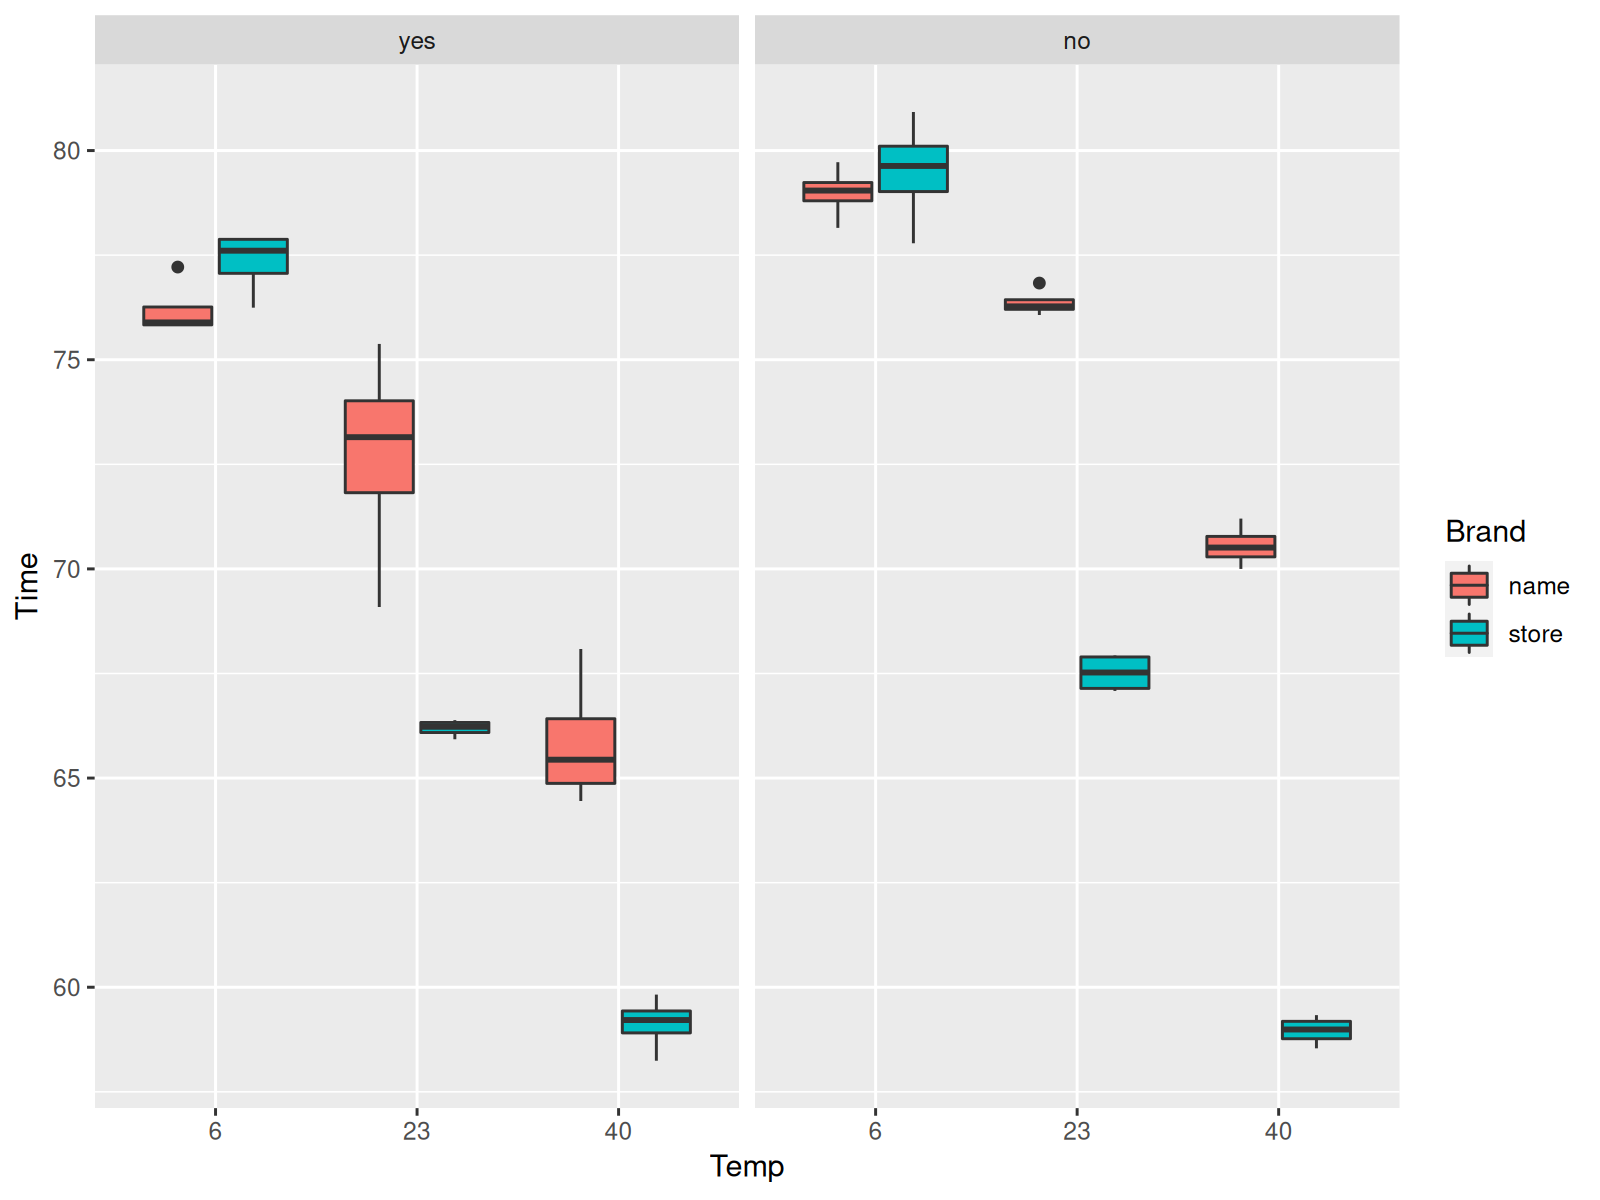

In [6]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
df_eff %>% ggplot() + geom_boxplot(aes(fill = Brand, y = Time, x = Temp)) + facet_grid(cols = vars(Stirred))

Of the various boxplots that were produced, this one shows that temperature does have a significant effect on dissolve times for the tablets. Temperature affected both store and name brands in roughly similar fashions.

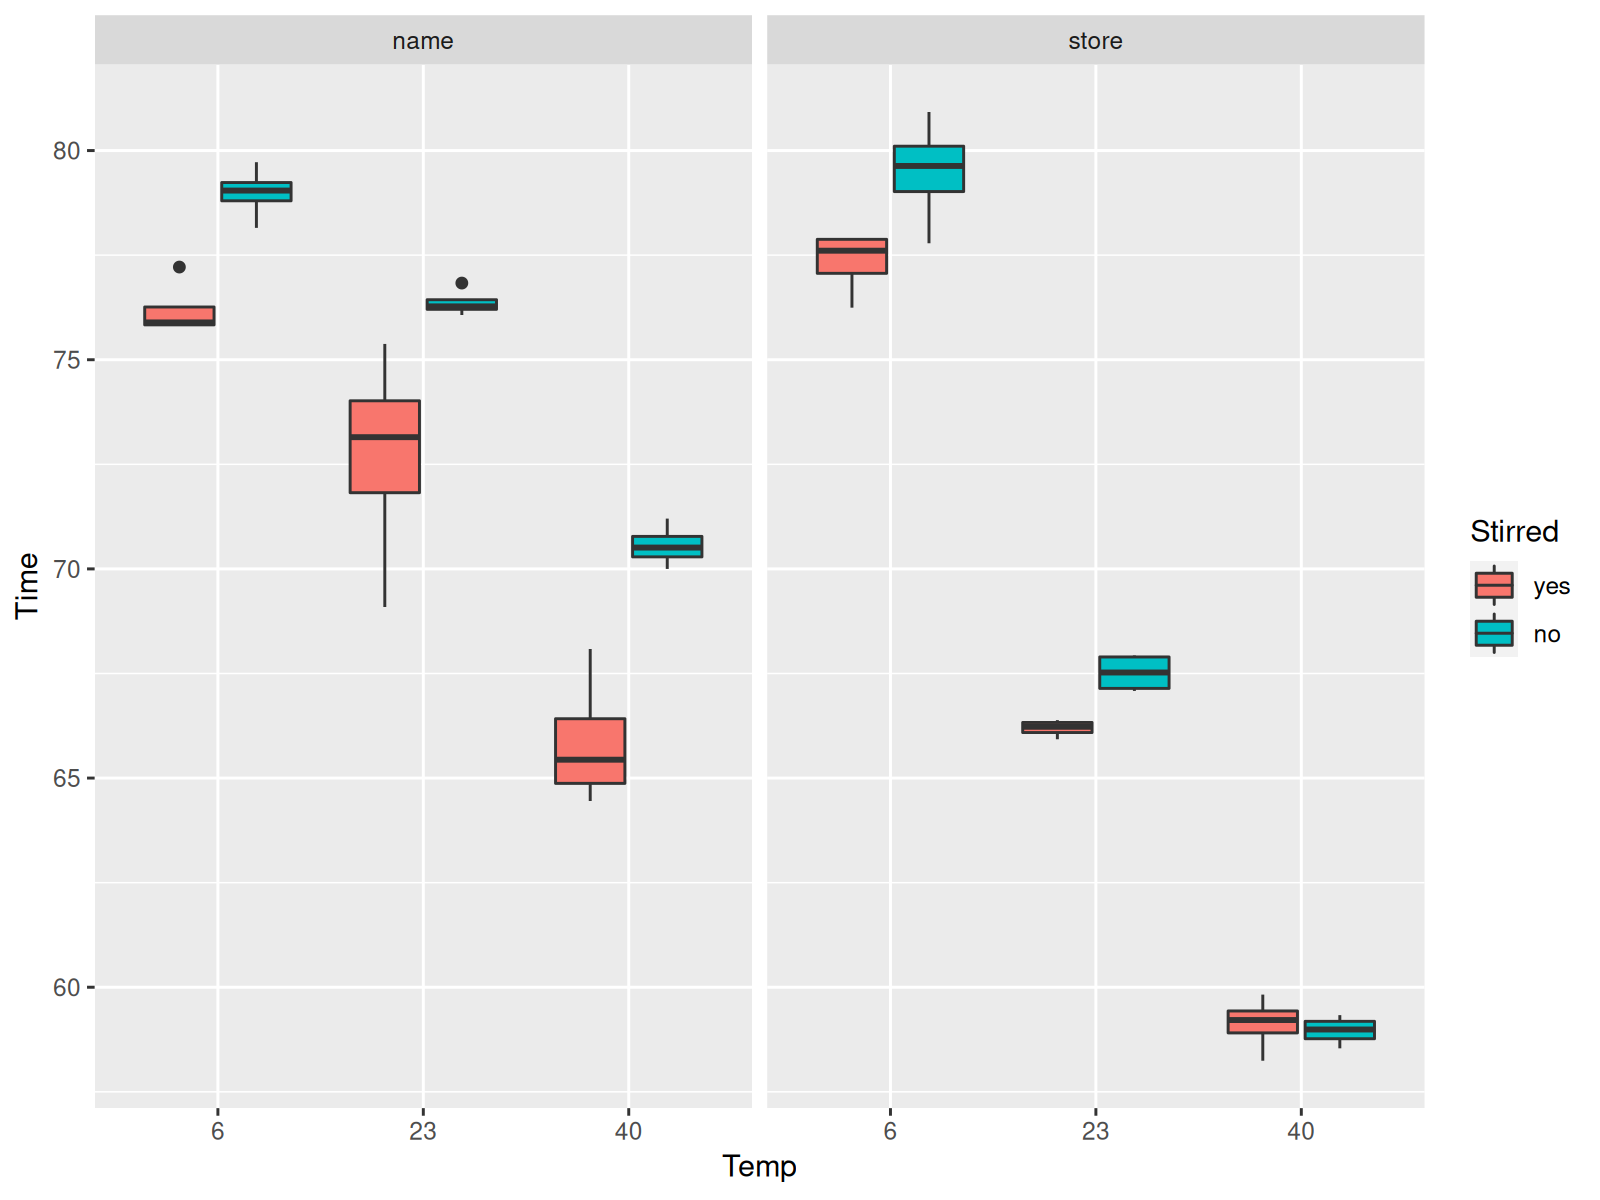

In [7]:
df_eff %>% ggplot() + geom_boxplot(aes(fill = Stirred, y = Time, x = Temp)) +  facet_grid(cols = vars(Brand))

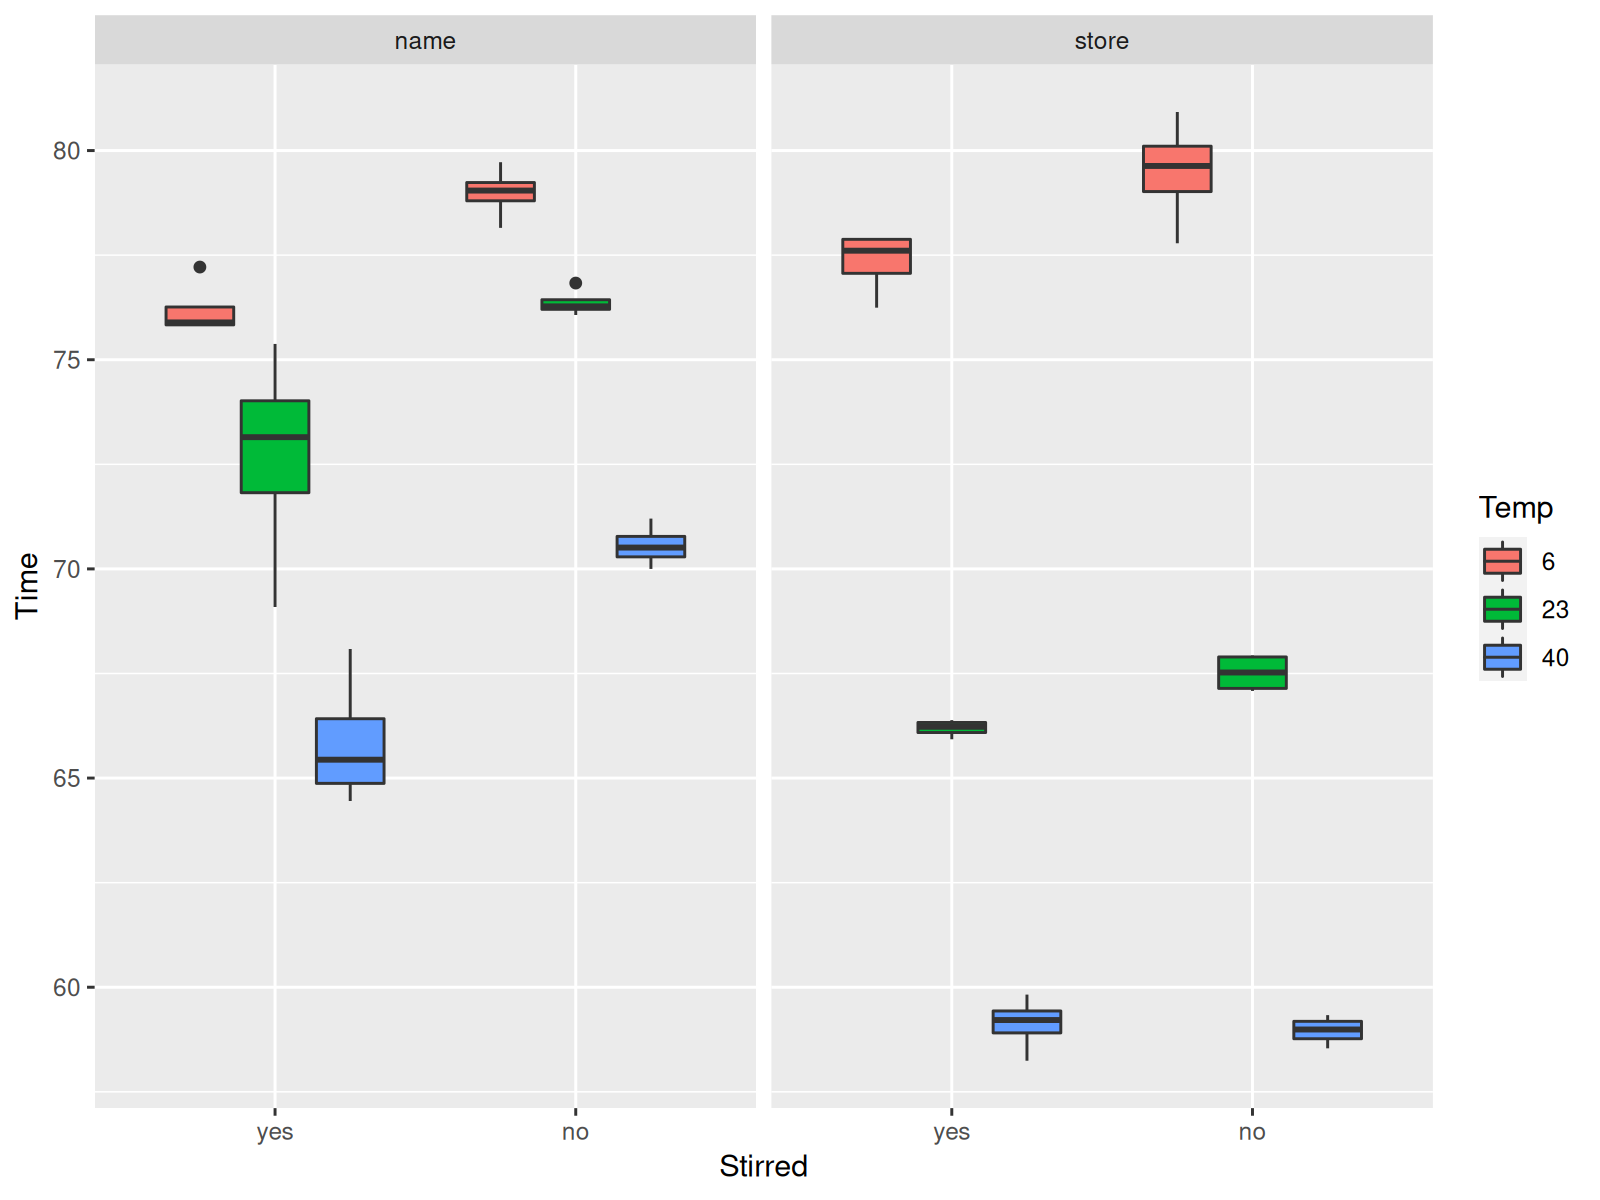

In [8]:
df_eff %>% ggplot() + geom_boxplot(aes(x = Stirred, y = Time, fill = Temp)) +  facet_grid(cols = vars(Brand))

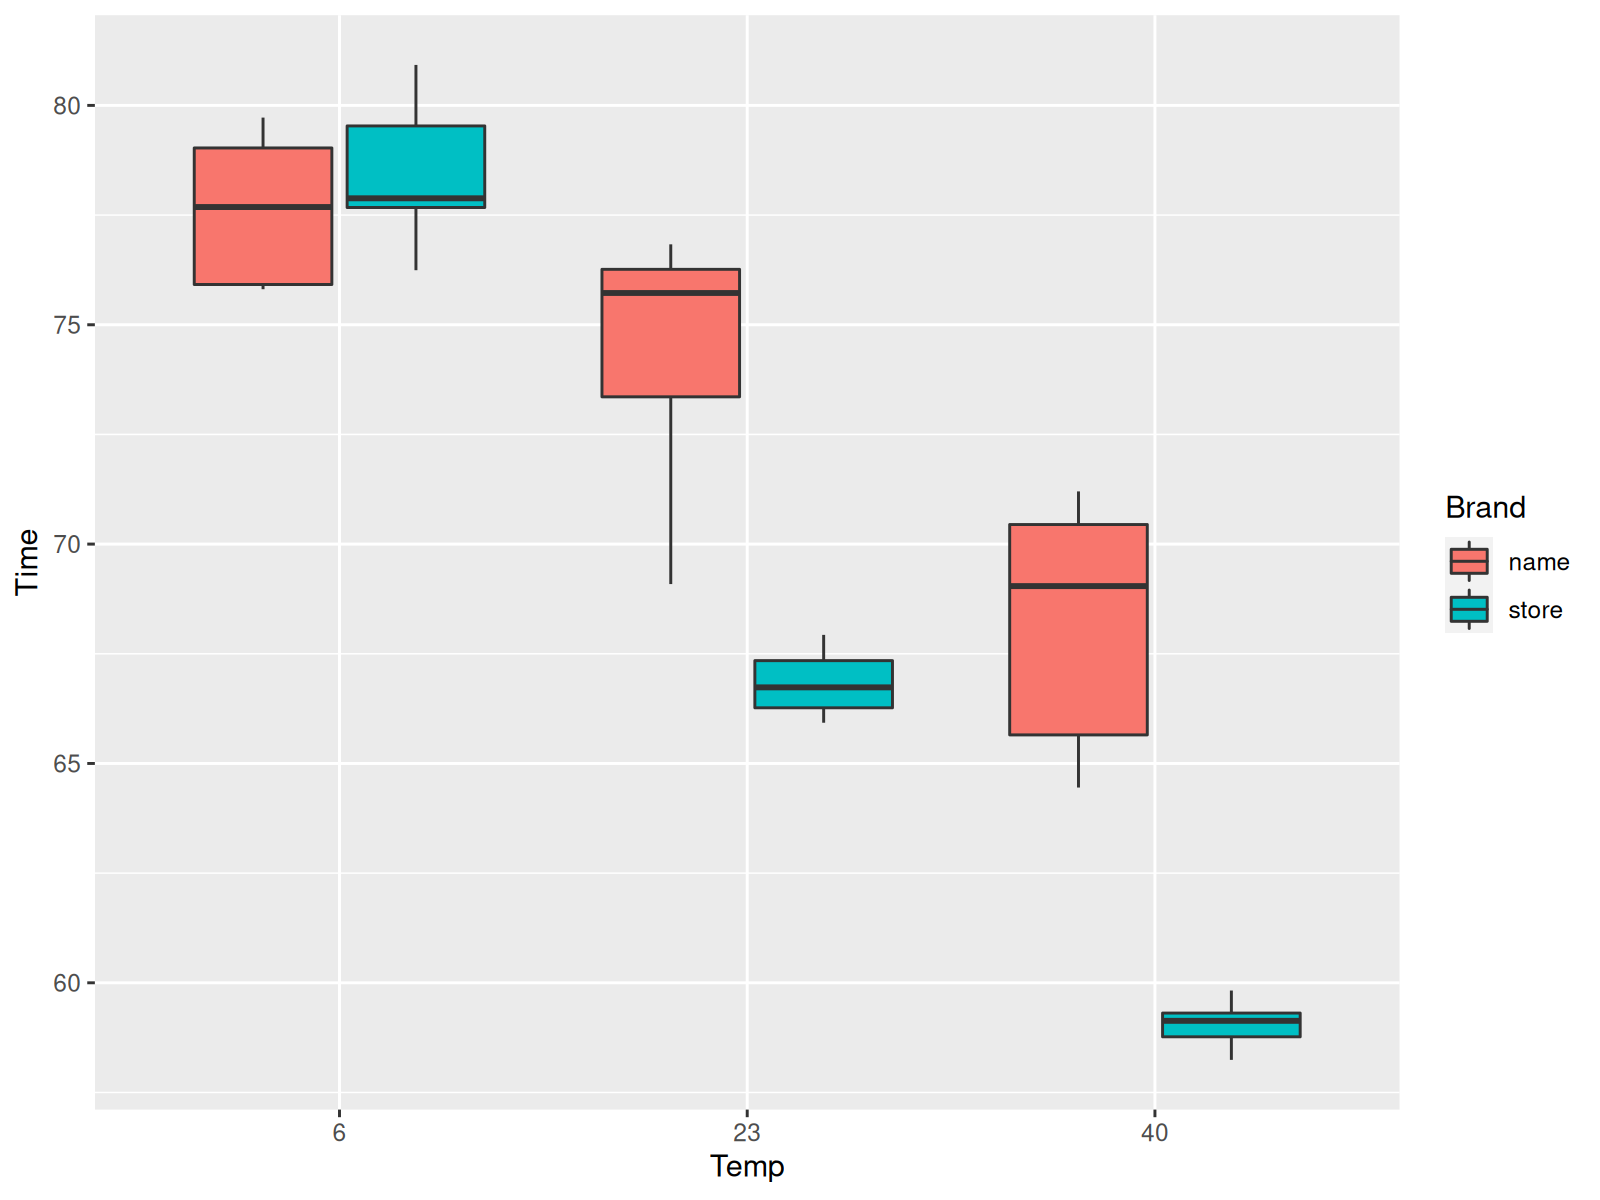

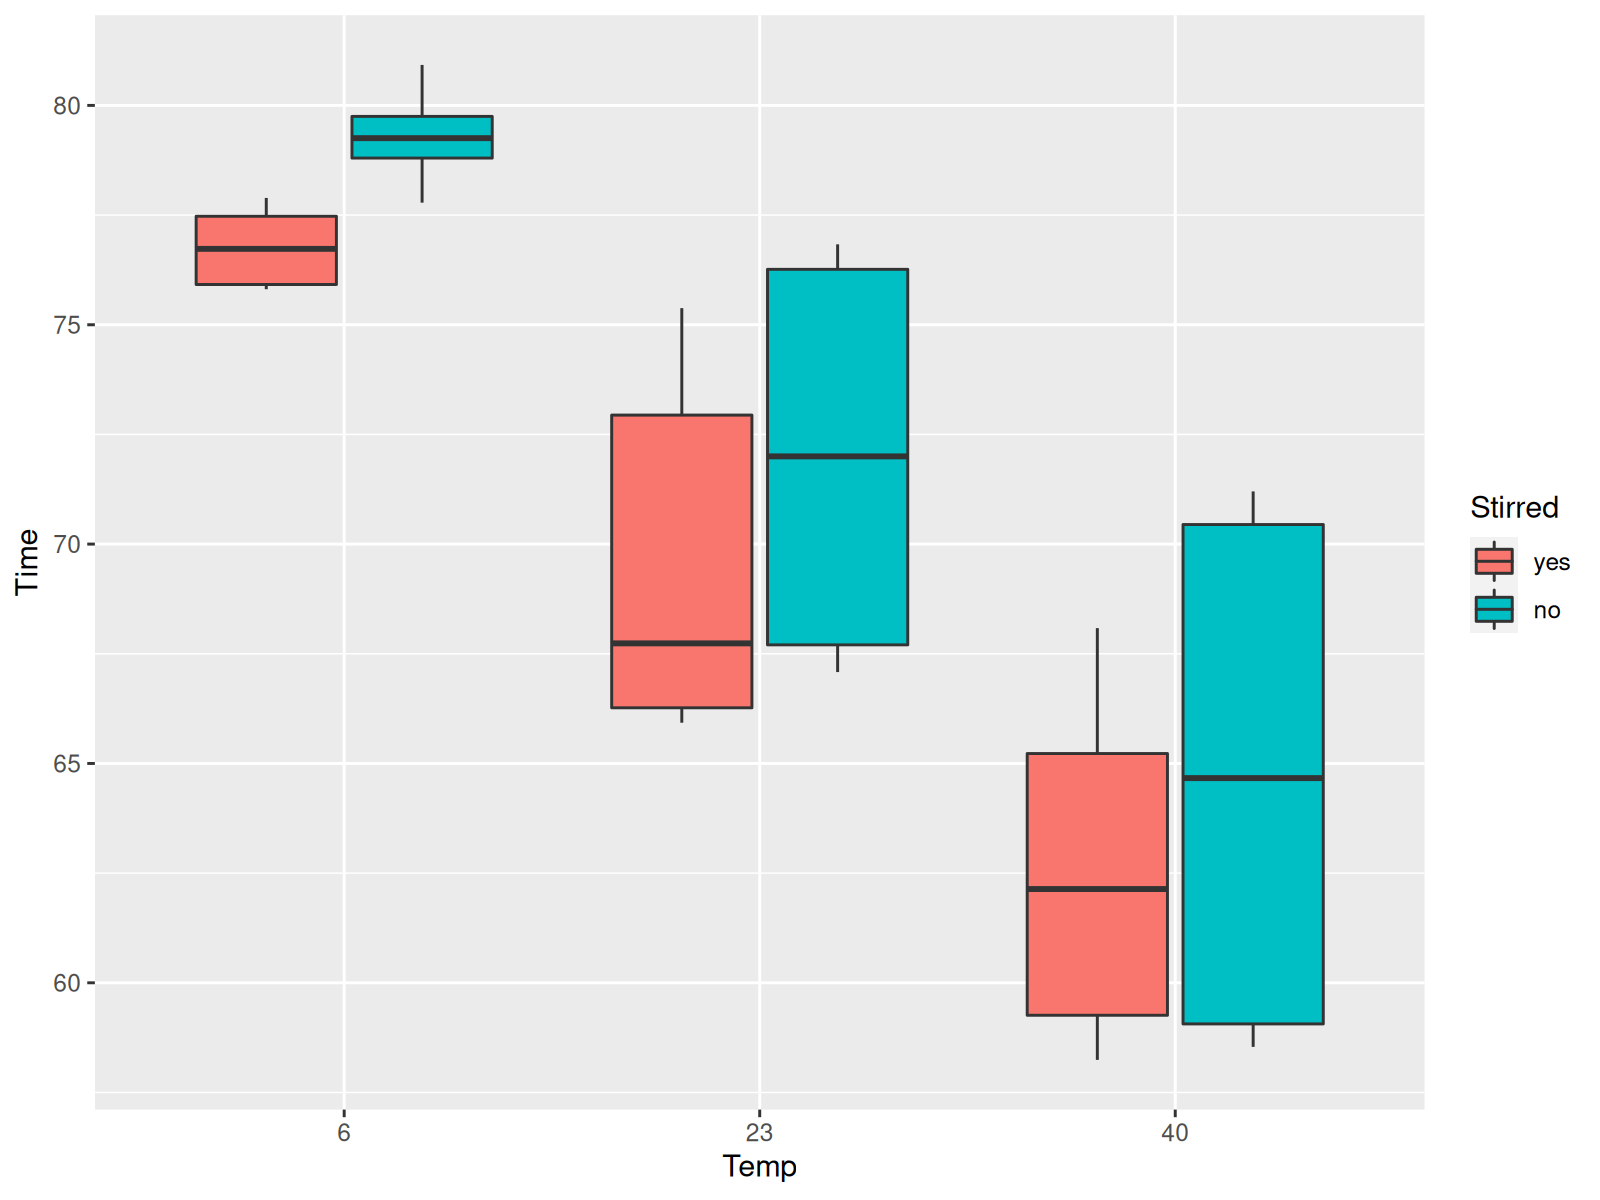

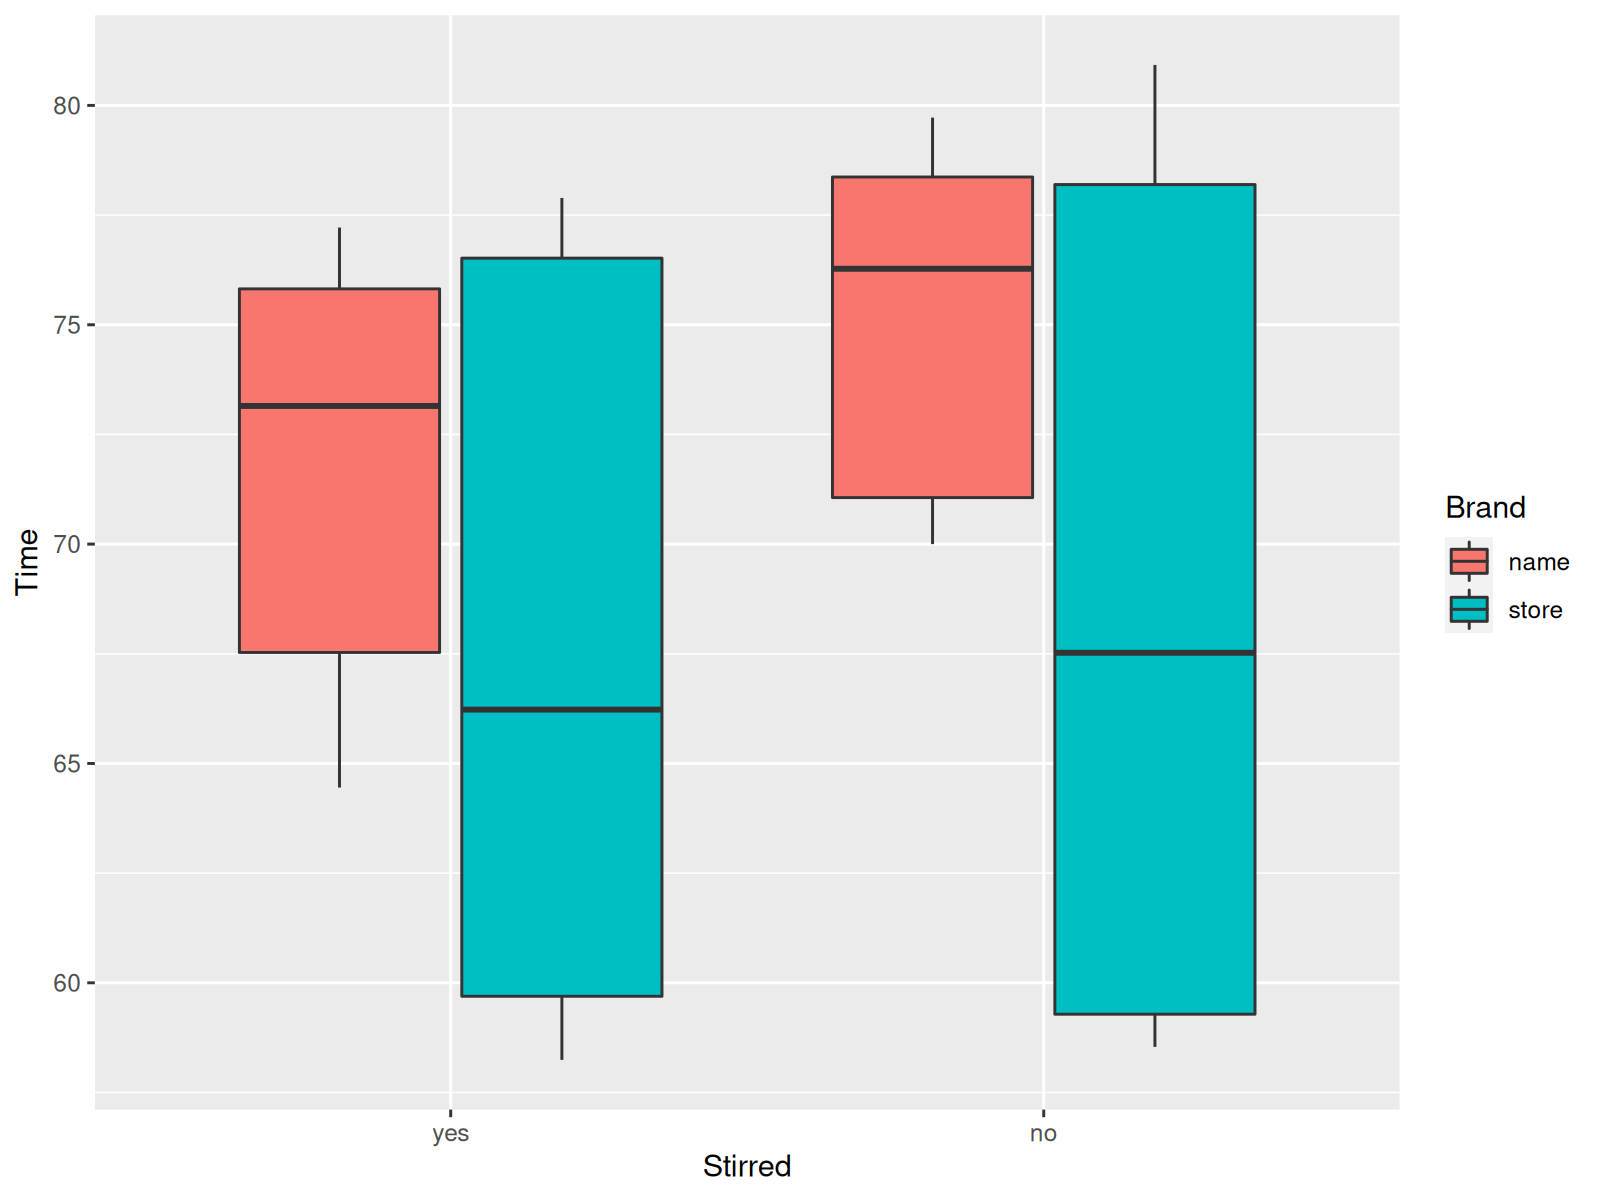

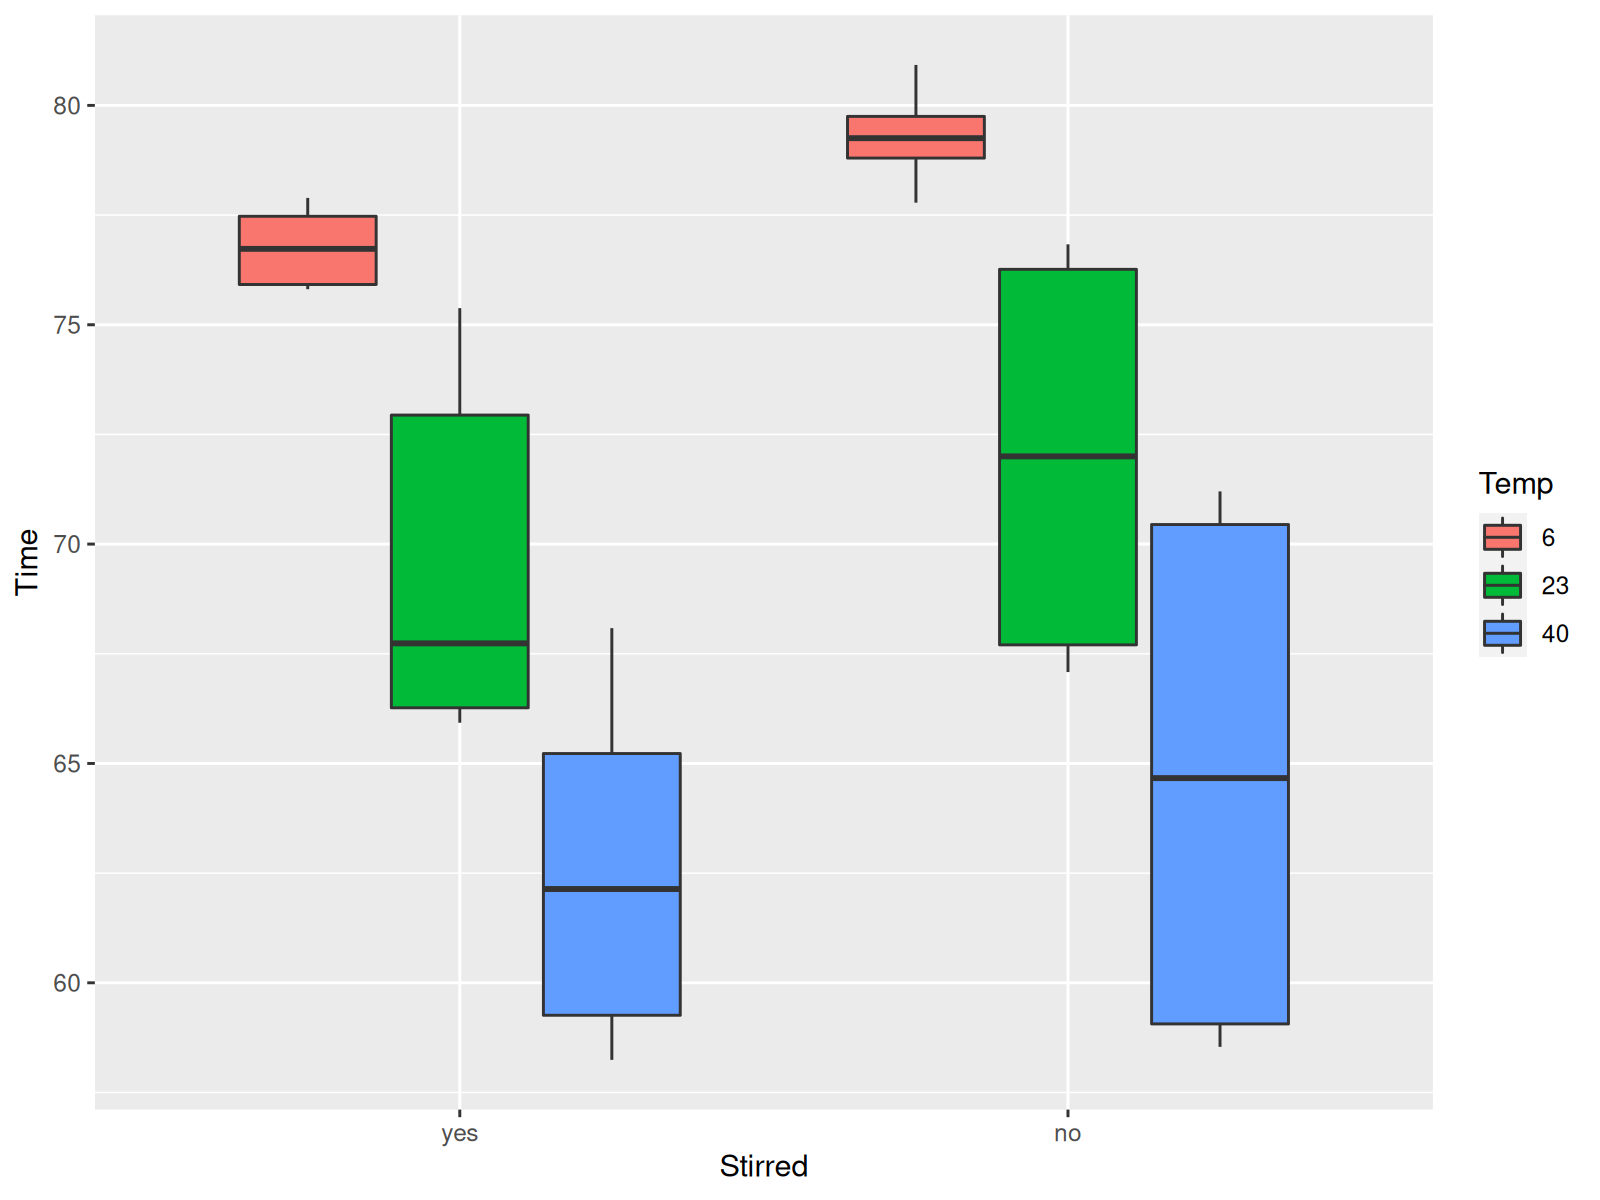

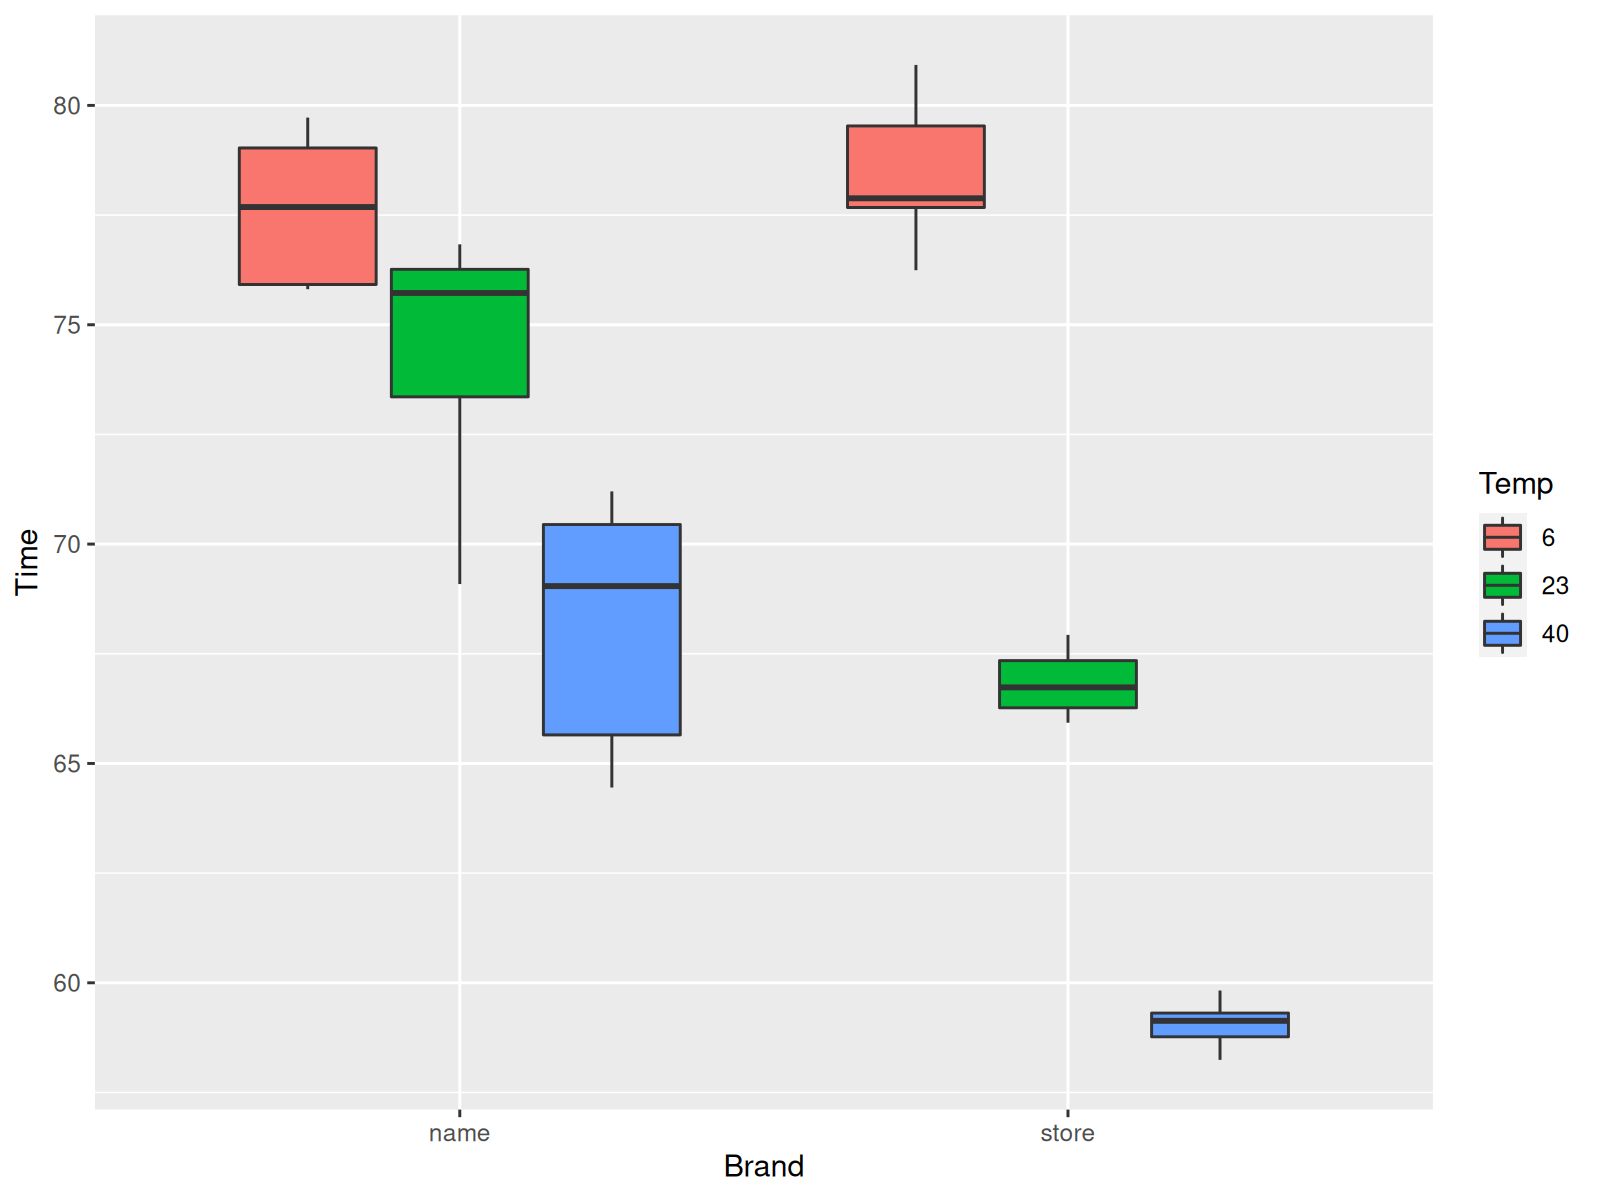

In [9]:
df_eff %>% ggplot() + geom_boxplot(aes(fill = Brand, y = Time, x = Temp))
df_eff %>% ggplot() + geom_boxplot(aes(fill = Stirred, y = Time, x = Temp))
df_eff %>% ggplot() + geom_boxplot(aes(fill = Brand, y = Time, x = Stirred))
df_eff %>% ggplot() + geom_boxplot(aes(fill = Temp, y = Time, x = Stirred))
df_eff %>% ggplot() + geom_boxplot(aes(fill = Temp, y = Time, x = Brand))

In [10]:
df_eff %>% group_by(Brand, Temp, Stirred) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'n' = n())
df_eff %>% group_by(Brand) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'n' = n())
df_eff %>% group_by(Temp) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'n' = n())
df_eff %>% group_by(Stirred) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'n' = n())

`summarise()` has grouped output by 'Brand', 'Temp'. You can override using the `.groups` argument.


Brand,Temp,Stirred,Mean,Var,n
<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>
name,6,yes,76.20241,0.45934925,4
name,6,no,78.99061,0.41464405,4
name,23,yes,72.69145,6.98690870,4
name,23,no,76.36351,0.10781342,4
name,40,yes,65.85343,2.54997510,4
name,40,no,70.55511,0.25440333,4
store,6,yes,77.33703,0.59648839,4
store,6,no,79.49240,1.69425169,4
store,23,yes,66.19126,0.04110242,4


Brand,Mean,Var,n
<fct>,<dbl>,<dbl>,<int>
name,73.44276,21.13144,24
store,68.10416,67.03190,24


Temp,Mean,Var,n
<fct>,<dbl>,<dbl>,<int>
6,78.00561,2.467426,16
23,70.69044,19.204515,16
40,63.62433,25.996561,16


Stirred,Mean,Var,n
<fct>,<dbl>,<dbl>,<int>
yes,69.56681,44.63986,24
no,71.98011,55.35476,24


`summarise()` has grouped output by 'Brand'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Temp'. You can override using the `.groups` argument.


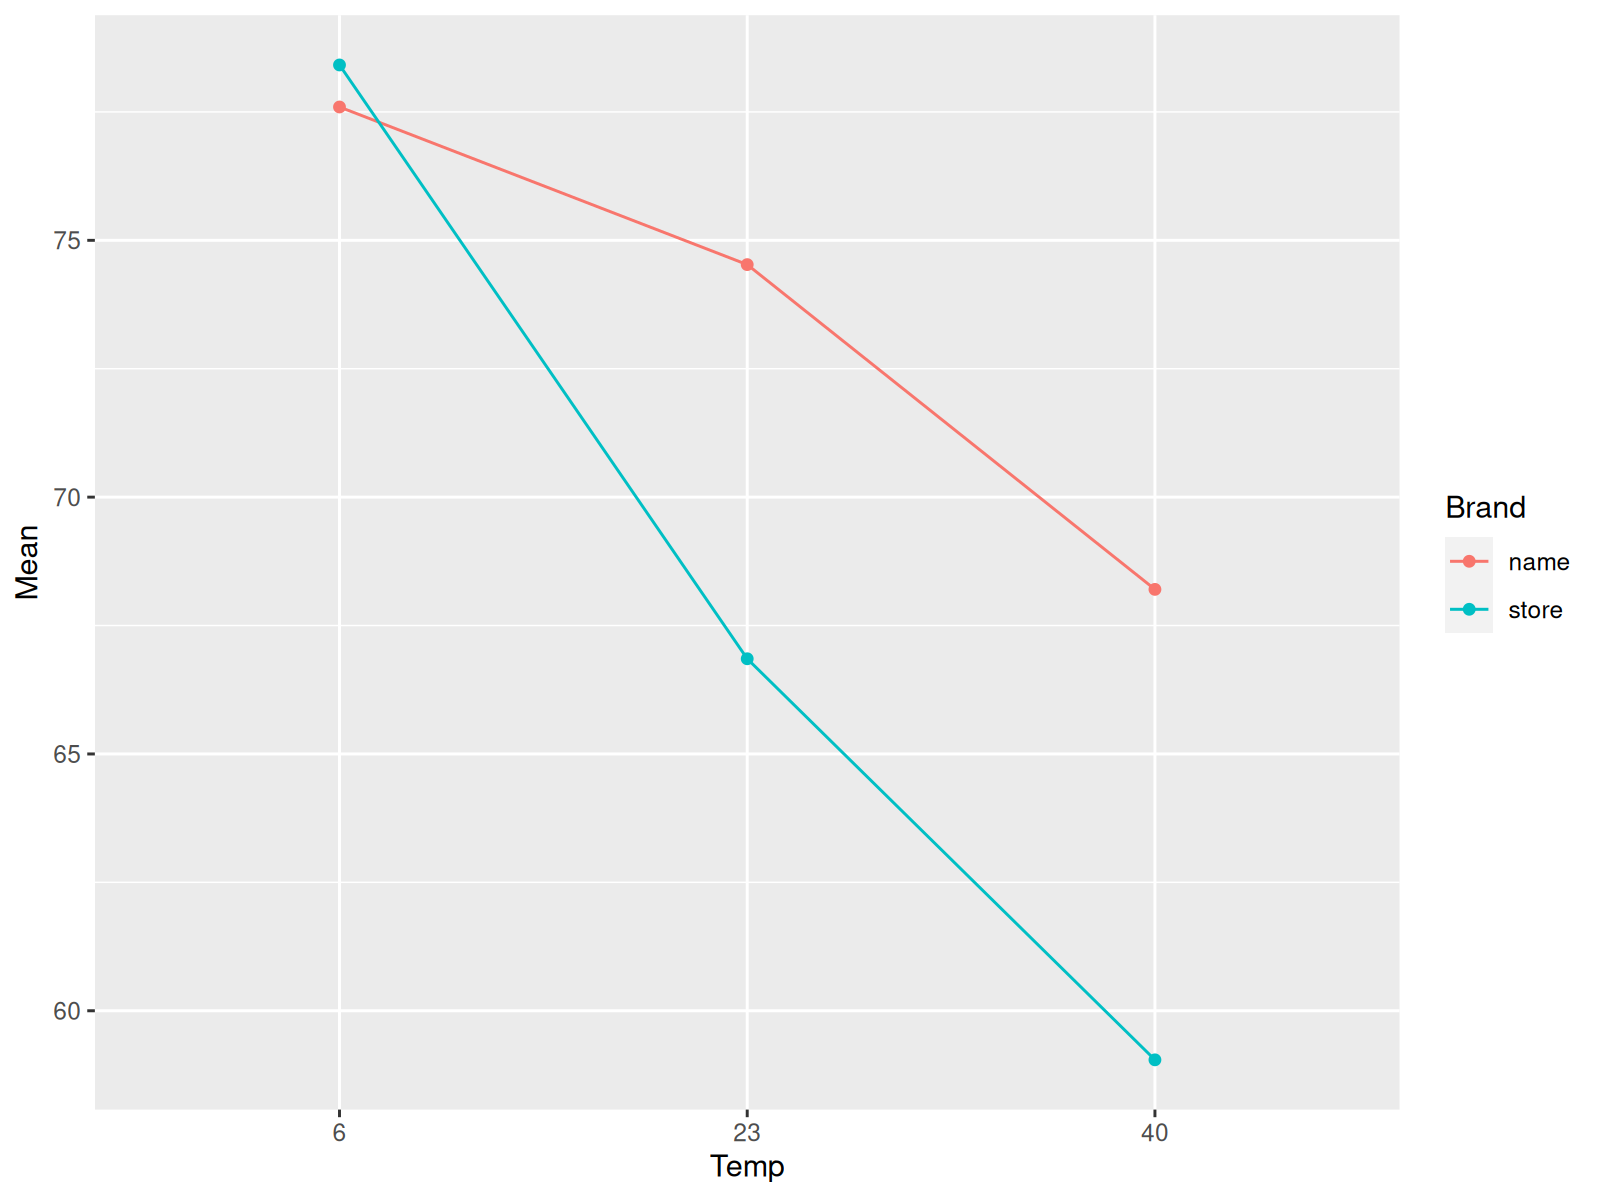

`summarise()` has grouped output by 'Stirred'. You can override using the `.groups` argument.


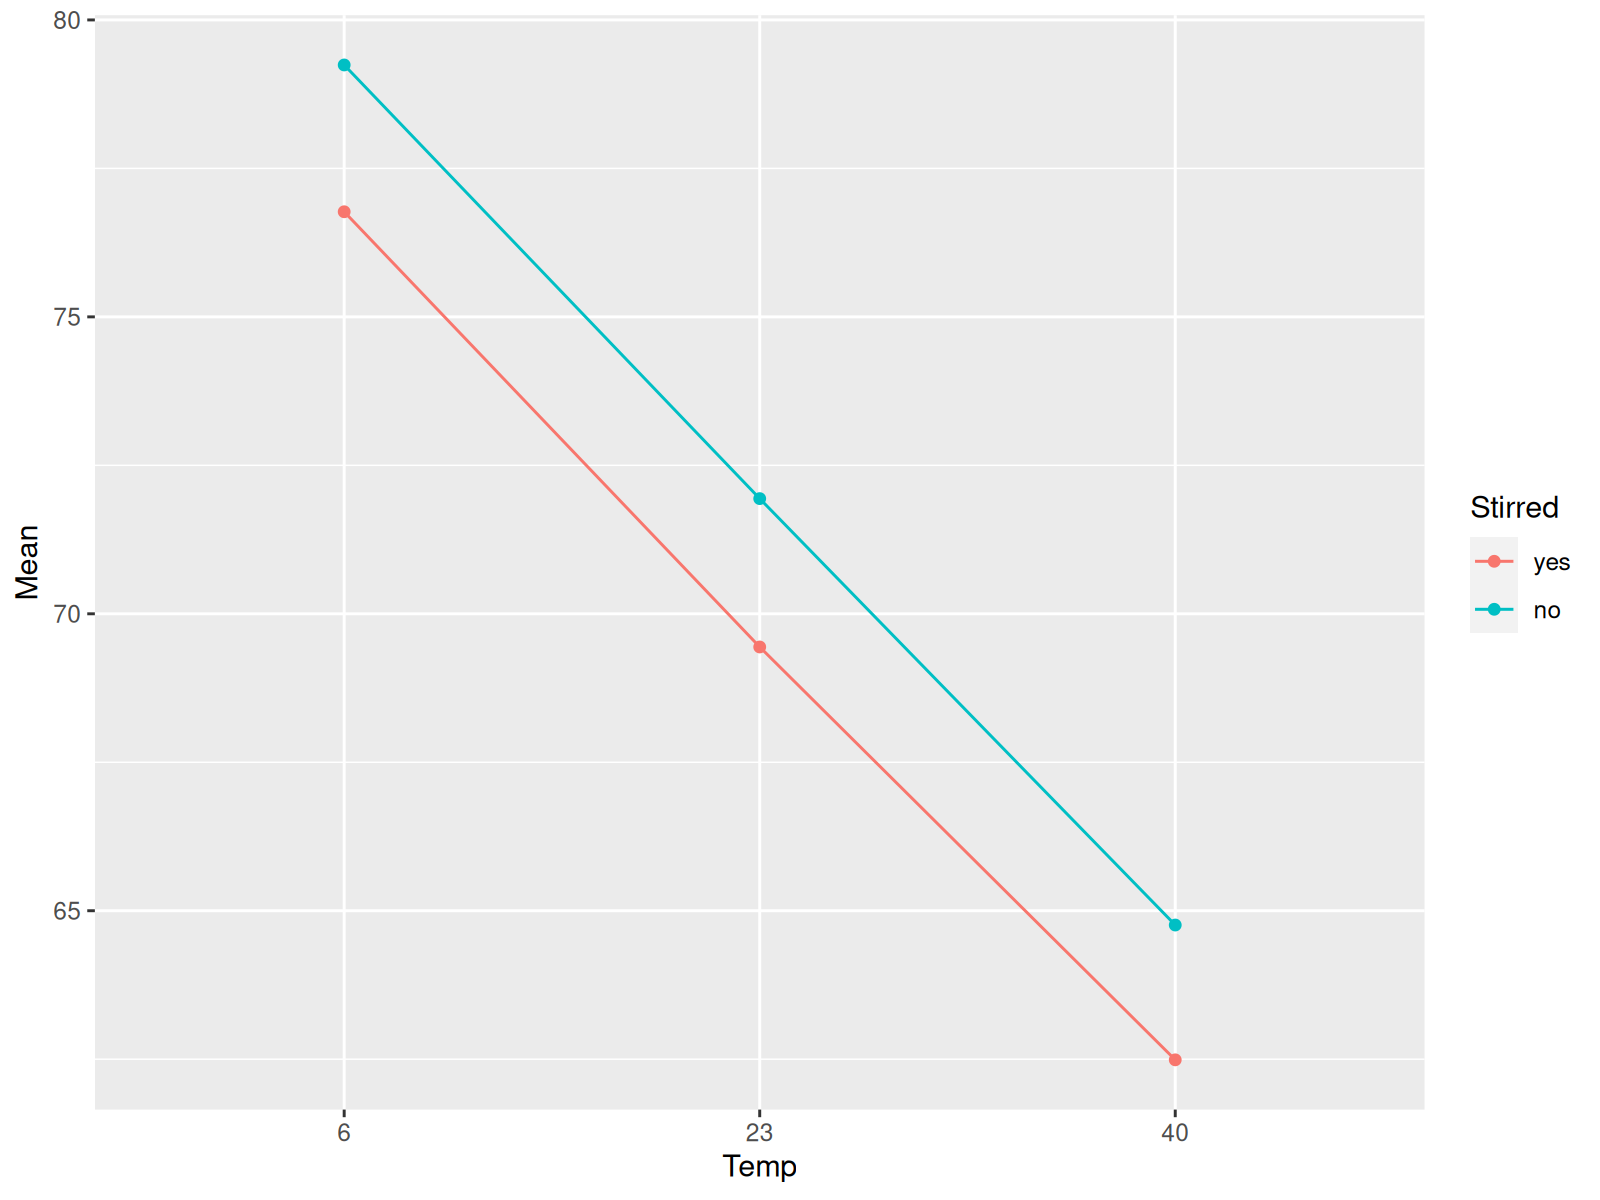

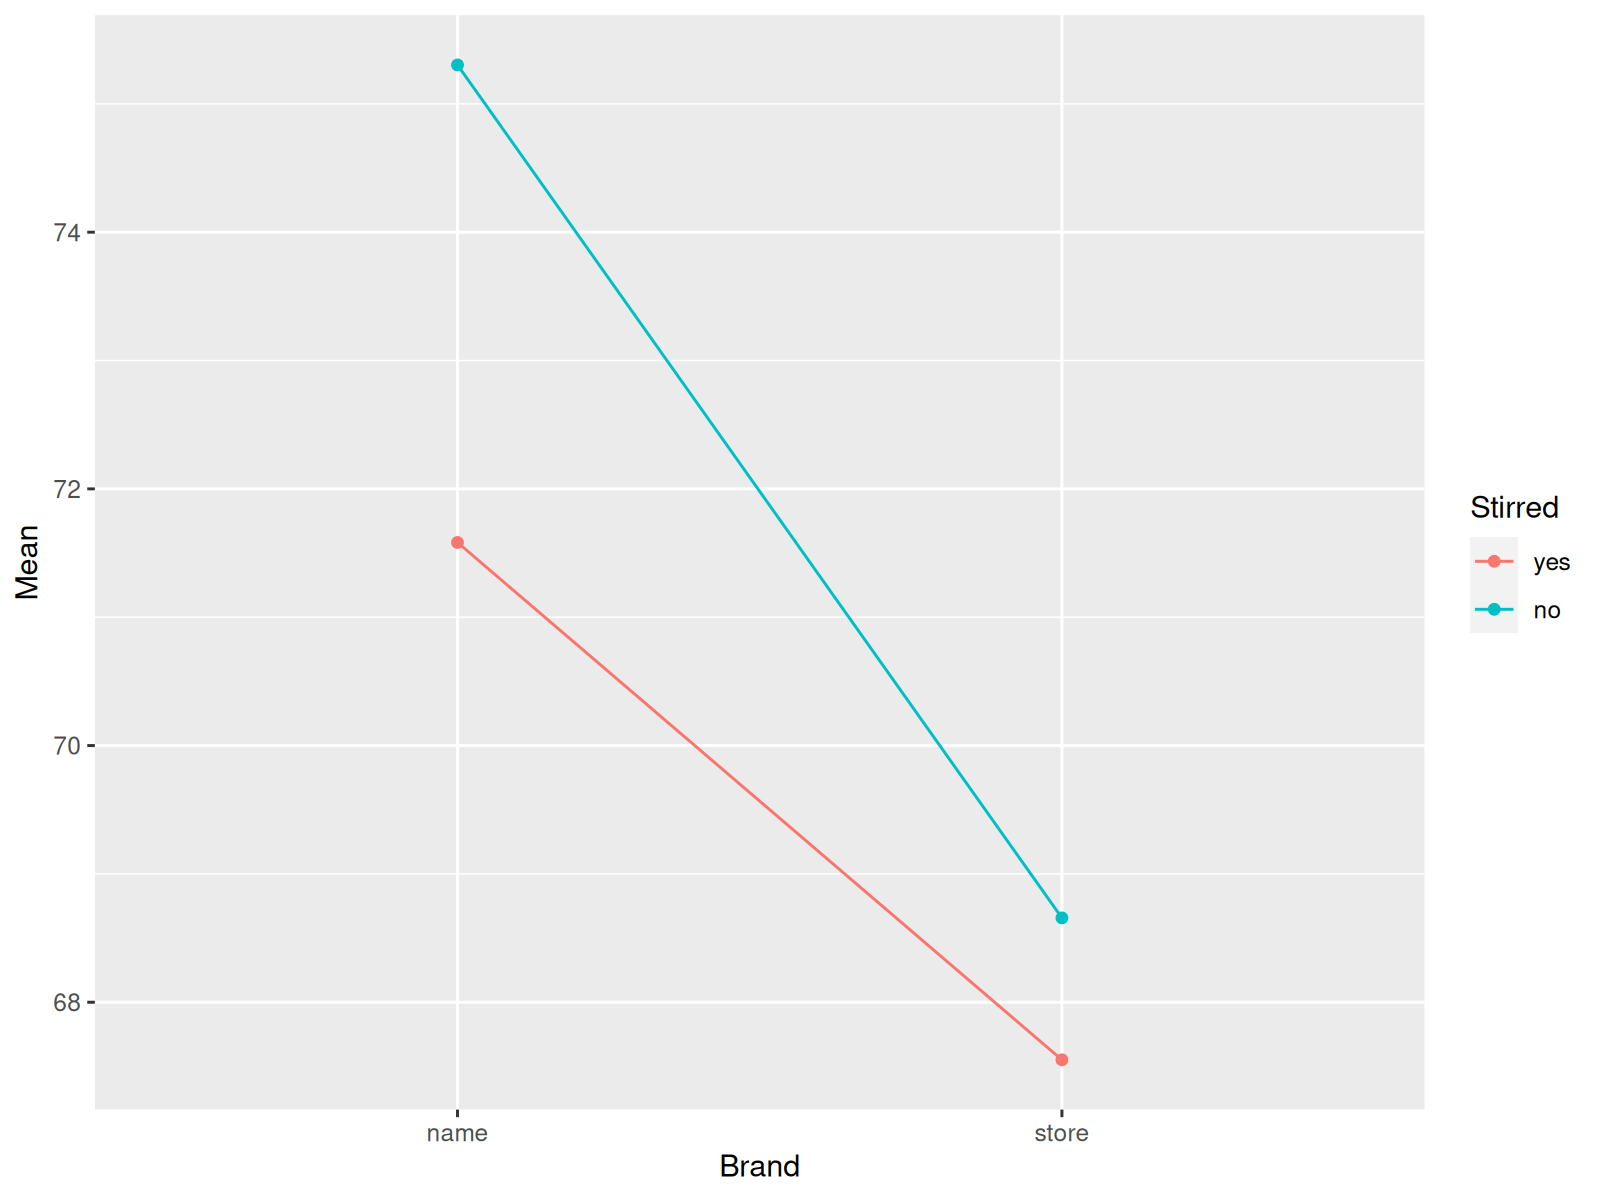

In [11]:
df_eff %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'n' = n()) %>% 
    ggplot(aes(y = Mean, group = Brand, x = Temp, col = Brand)) + geom_line() + geom_point()
df_eff %>% group_by(Temp, Stirred) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'n' = n()) %>% 
    ggplot(aes(y = Mean, group = Stirred, x = Temp, col = Stirred)) + geom_line() + geom_point()
df_eff %>% group_by(Stirred, Brand) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'n' = n()) %>% 
    ggplot(aes(y = Mean, group = Stirred, x = Brand, col = Stirred)) + geom_line() + geom_point()

In [12]:
aov_eff <- aov(lm_eff <- lm(Time ~ Brand * Temp * Stirred, data = df_eff))
summary(lm_eff)
summary(aov_eff)
print(Anova(lm(Time ~ Brand * Temp * Stirred, data = df_eff), type = 3))


Call:
lm(formula = Time ~ Brand * Temp * Stirred, data = df_eff)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6021 -0.3538  0.0077  0.3816  2.6871 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  76.2024     0.5374 141.794  < 2e-16 ***
Brandstore                    1.1346     0.7600   1.493 0.144185    
Temp23                       -3.5110     0.7600  -4.620 4.78e-05 ***
Temp40                      -10.3490     0.7600 -13.617 9.05e-16 ***
Stirredno                     2.7882     0.7600   3.669 0.000783 ***
Brandstore:Temp23            -7.6348     1.0748  -7.103 2.40e-08 ***
Brandstore:Temp40            -7.8628     1.0748  -7.315 1.27e-08 ***
Brandstore:Stirredno         -0.6328     1.0748  -0.589 0.559694    
Temp23:Stirredno              0.8839     1.0748   0.822 0.416308    
Temp40:Stirredno              1.9135     1.0748   1.780 0.083476 .  
Brandstore:Temp23:Stirredno  -1.7150     1.5200  -1.128 0.266685  

                   Df Sum Sq Mean Sq F value   Pr(>F)    
Brand               1  342.0   342.0 296.041  < 2e-16 ***
Temp                2 1654.7   827.4 716.169  < 2e-16 ***
Stirred             1   69.9    69.9  60.495 3.22e-09 ***
Brand:Temp          2  231.9   115.9 100.345 1.90e-15 ***
Brand:Stirred       1   20.5    20.5  17.753 0.000161 ***
Temp:Stirred        2    0.1     0.1   0.054 0.947535    
Brand:Temp:Stirred  2    9.1     4.5   3.919 0.028838 *  
Residuals          36   41.6     1.2                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova Table (Type III tests)

Response: Time
                    Sum Sq Df    F value    Pr(>F)    
(Intercept)        23227.2  1 20105.4508 < 2.2e-16 ***
Brand                  2.6  1     2.2287 0.1441852    
Temp                 221.6  2    95.9006 3.780e-15 ***
Stirred               15.5  1    13.4584 0.0007832 ***
Brand:Temp            80.1  2    34.6716 4.041e-09 ***
Brand:Stirred          0.4  1     0.3466 0.5596939    
Temp:Stirred           3.7  2     1.5877 0.2183718    
Brand:Temp:Stirred     9.1  2     3.9195 0.0288376 *  
Residuals             41.6 36                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


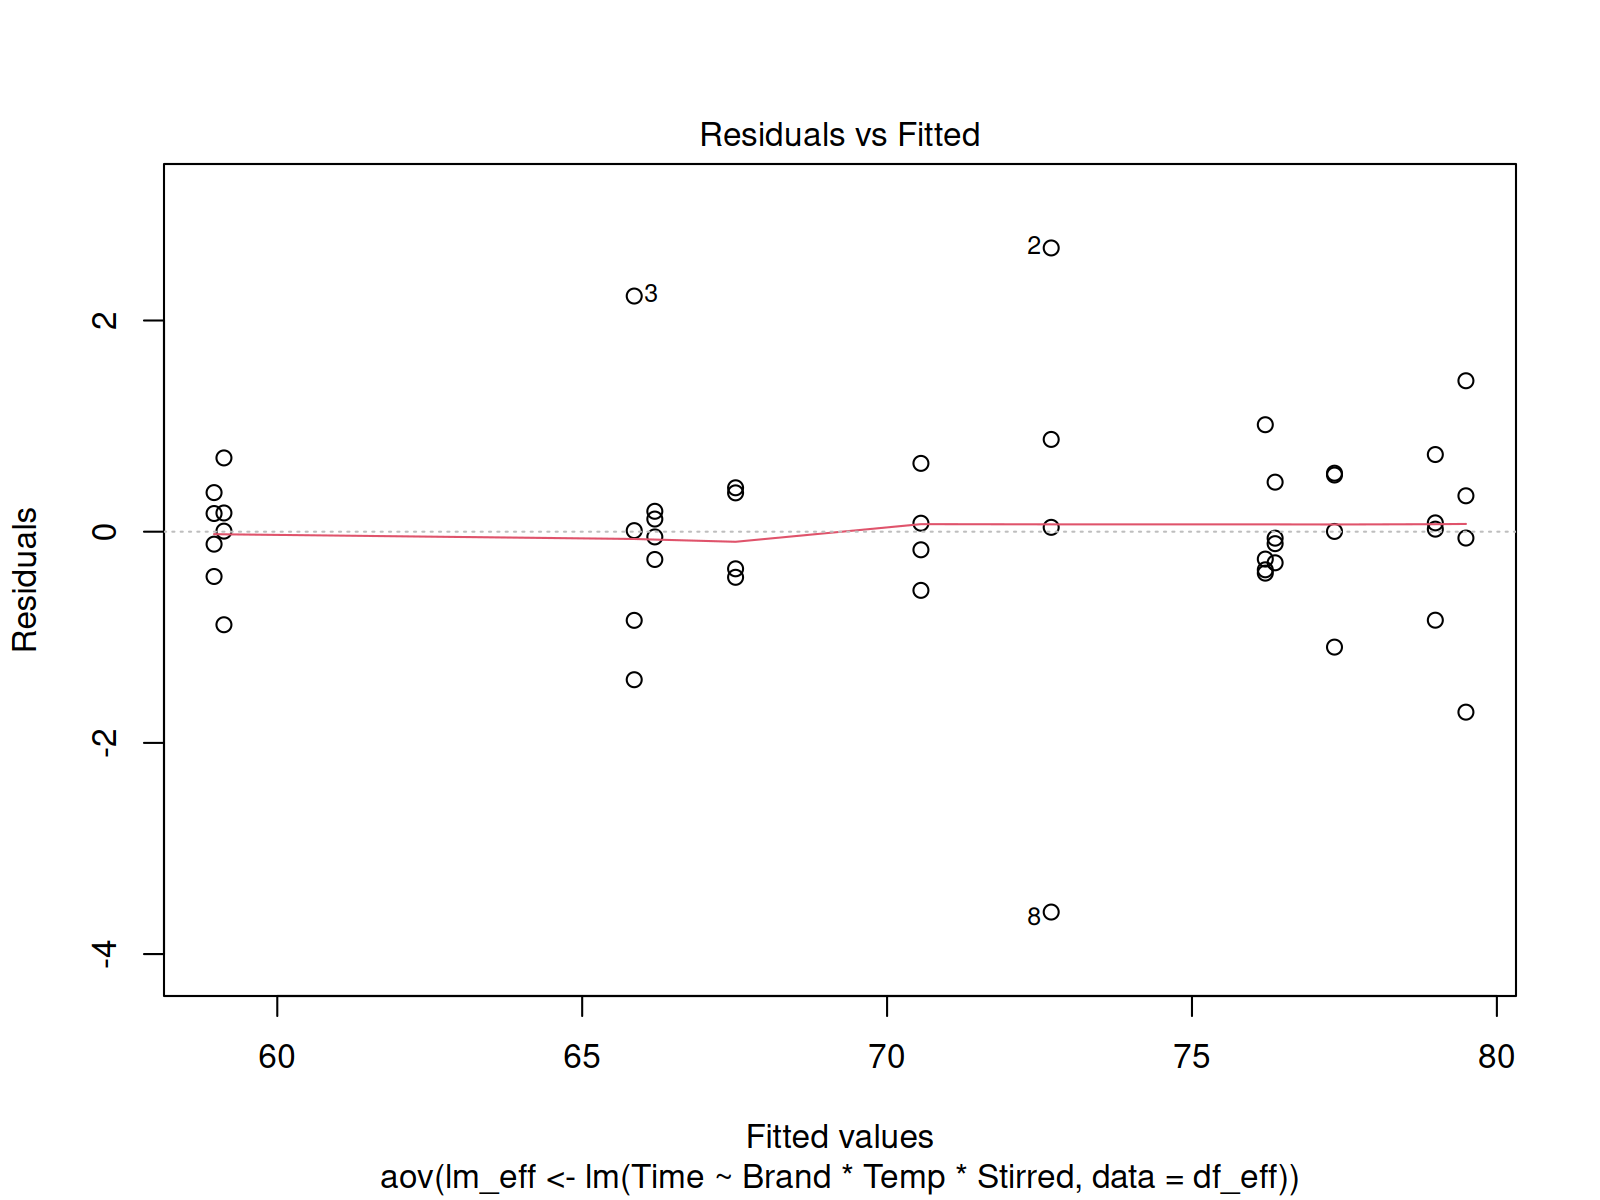

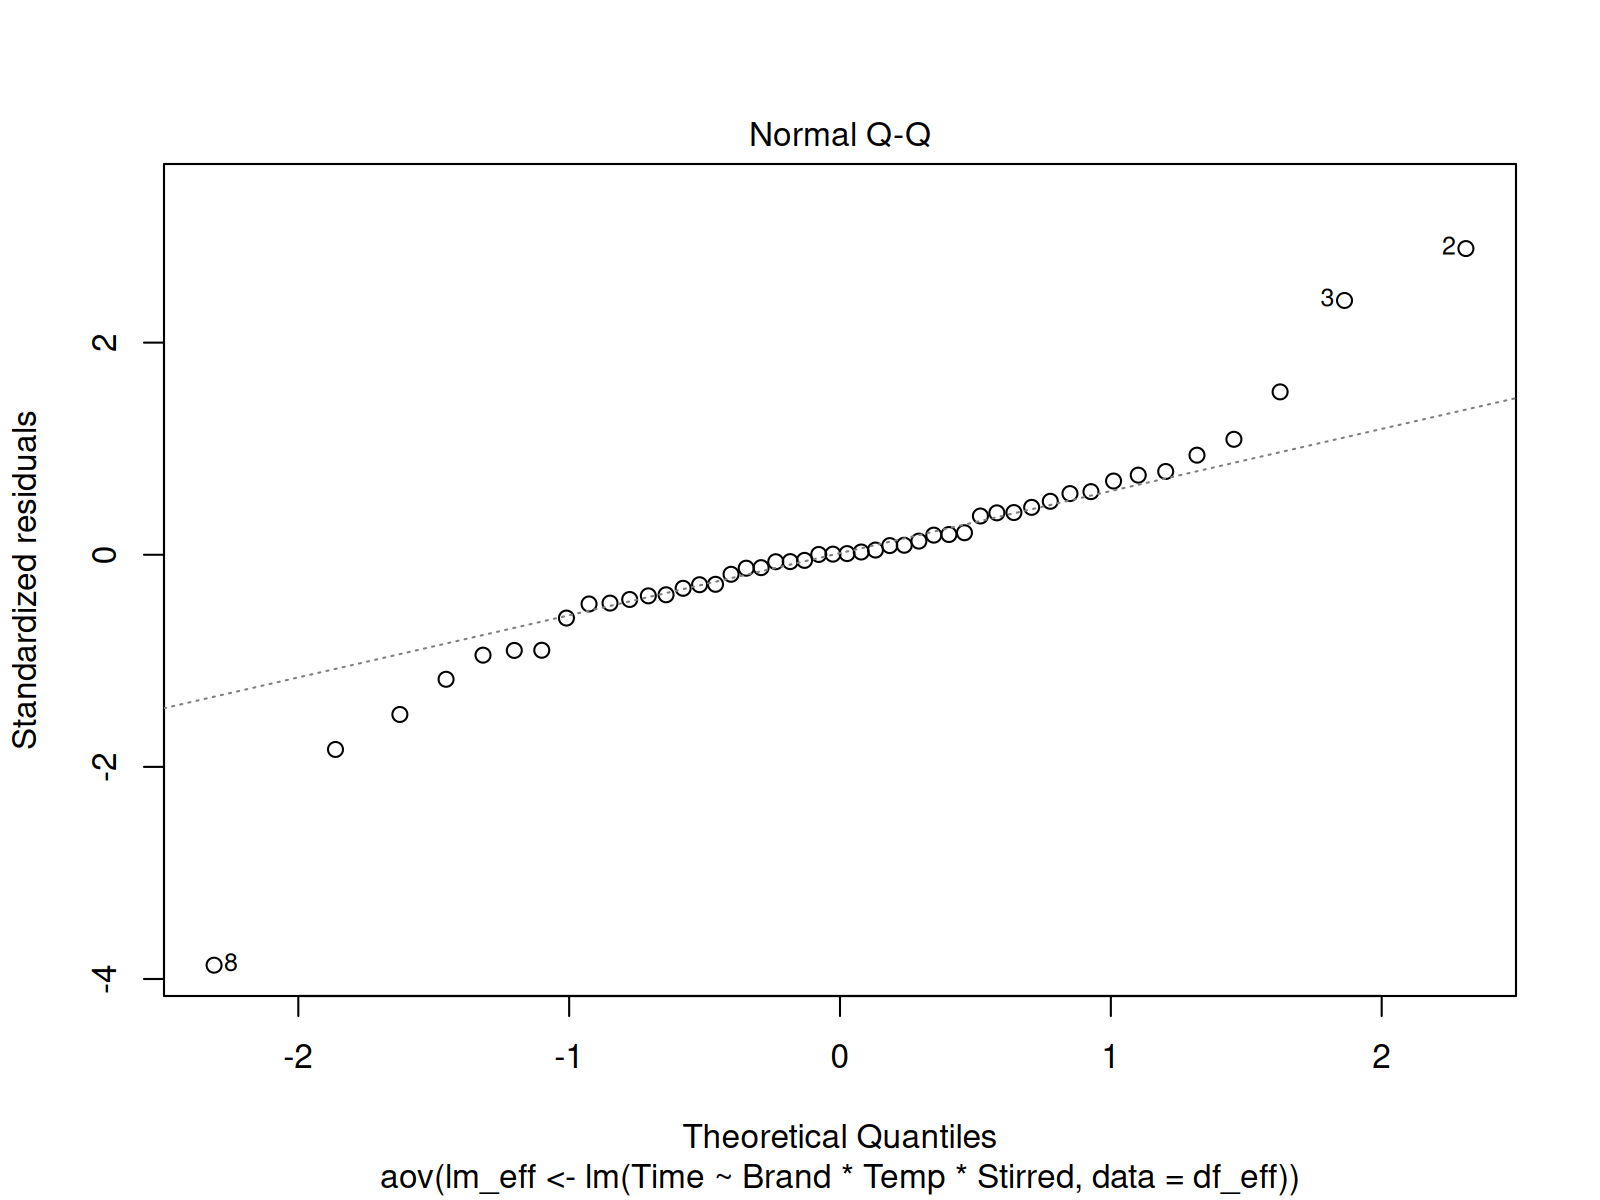

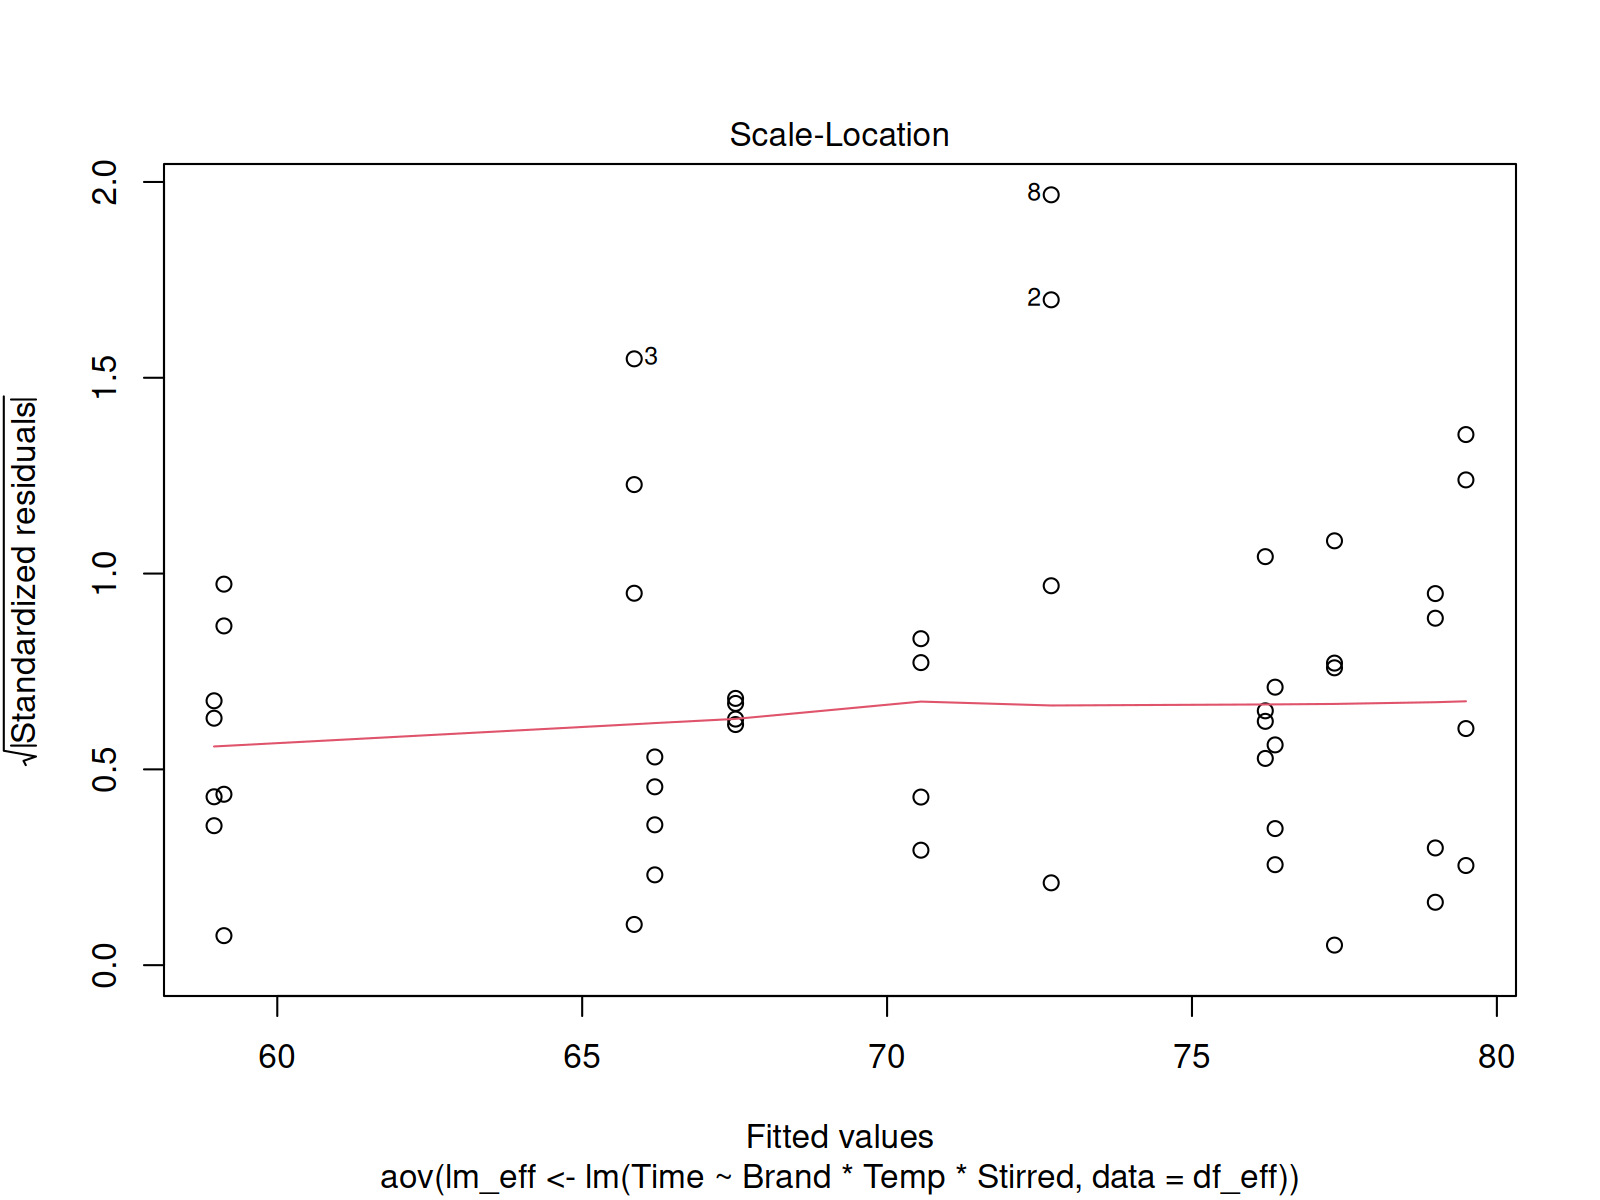

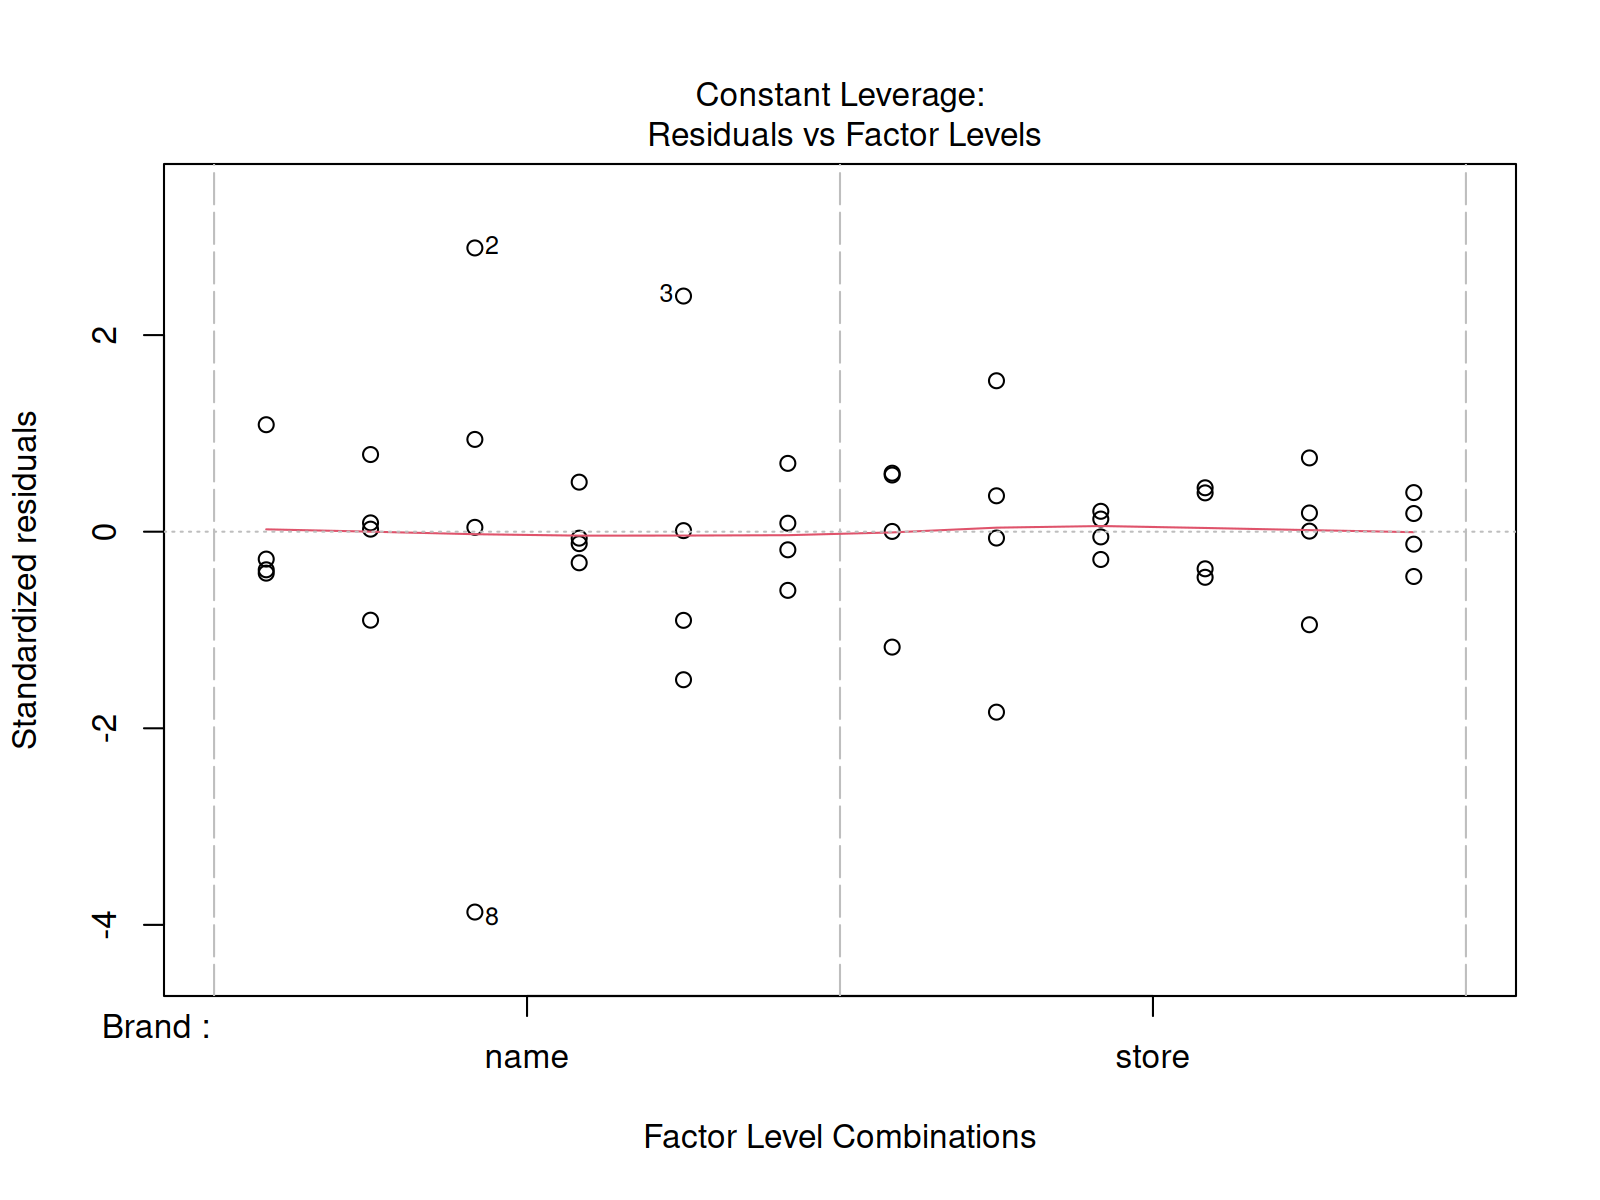

In [13]:
plot(aov_eff)

In [14]:
means_eff <- emmeans(aov_eff, specs = c('Brand', 'Temp', 'Stirred'))
summary(means_eff)

,Brand,Temp,Stirred,emmean,SE,df,lower.CL,upper.CL
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,name,6,yes,76.20241,0.5374175,36,75.11248,77.29235
2,store,6,yes,77.33703,0.5374175,36,76.24709,78.42696
3,name,23,yes,72.69145,0.5374175,36,71.60152,73.78138
4,store,23,yes,66.19126,0.5374175,36,65.10132,67.28119
5,name,40,yes,65.85343,0.5374175,36,64.76350,66.94337
6,store,40,yes,59.12529,0.5374175,36,58.03535,60.21522
7,name,6,no,78.99061,0.5374175,36,77.90068,80.08055
8,store,6,no,79.49240,0.5374175,36,78.40247,80.58233
9,name,23,no,76.36351,0.5374175,36,75.27358,77.45344


In [15]:
sum(unname(lm_eff$coeff) * c(1,1,0,0,1,0,0,1,0,0,0,0))

[1] 79.4924

In [16]:
contrast(means_eff, list(stirred = c(1/6,1/6,1/6,1/6,1/6,1/6,-1/6,-1/6,-1/6,-1/6,-1/6,-1/6),
                         branding = rep(c(1/6,-1/6),6)))

 contrast estimate   SE df t.ratio p.value
 stirred     -2.41 0.31 36  -7.778  <.0001
 branding     5.34 0.31 36  17.206  <.0001


In [17]:
cont_str_brd <-
contrast(means_eff, list(stirred = c(1/6, 1/6, 1/6, 1/6, 1/6, 1/6, -1/6, -1/6, -1/6, -1/6, -1/6, -1/6),
                         branding = rep(c(1/6,-1/6), 6)
                         )
         )

cont_strbrd <-

contrast(means_eff, list(stirredbrand = c(1/3, 0,  1/3, 0, 1/3, 0, -1/3, 0, -1/3, 0, -1/3, 0),
                         stirredstore = c(0, 1/3, 0,  1/3, 0, 1/3, 0, -1/3, 0, -1/3, 0, -1/3),
                         stirredbrdstr = c(1/3, -1/3, 1/3, -1/3, 1/3, -1/3, 0, 0, 0, 0, 0, 0),
                         nonstirbrdstr = c(0, 0, 0, 0, 0, 0 , 1/3, -1/3, 1/3, -1/3, 1/3, -1/3)
                         )
         )
cont_temp <- 
contrast(means_eff, list(temp6_23 = c(1/4, 1/4, -1/4, -1/4, 0, 0, 1/4, 1/4, -1/4, -1/4, 0, 0),
                         temp6_40 = c(1/4, 1/4, 0, 0, -1/4, -1/4, 1/4, 1/4, 0, 0, -1/4, -1/4),
                         temp23_40 = c(0, 0, 1/4, 1/4, -1/4, -1/4, 0, 0, 1/4, 1/4, -1/4, -1/4)
                         )
         )
print(confint(cont_str_brd))
print(confint(cont_strbrd))
print(confint(cont_temp))

 contrast estimate   SE df lower.CL upper.CL
 stirred     -2.41 0.31 36    -3.04    -1.78
 branding     5.34 0.31 36     4.71     5.97

Confidence level used: 0.95 
 contrast      estimate    SE df lower.CL upper.CL
 stirredbrand     -3.72 0.439 36    -4.61   -2.831
 stirredstore     -1.11 0.439 36    -2.00   -0.216
 stirredbrdstr     4.03 0.439 36     3.14    4.921
 nonstirbrdstr     6.65 0.439 36     5.76    7.536

Confidence level used: 0.95 
 contrast  estimate   SE df lower.CL upper.CL
 temp6_23      7.32 0.38 36     6.54     8.09
 temp6_40     14.38 0.38 36    13.61    15.15
 temp23_40     7.07 0.38 36     6.30     7.84

Confidence level used: 0.95 


In [18]:
c(1/3, 0,  1/3, 0, 1/3, 0, -1/3, 0, -1/3, 0, -1/3, 0) - c(0, 1/3, 0,  1/3, 0, 1/3, 0, -1/3, 0, -1/3, 0, -1/3)

[1]  0.3333333 -0.3333333  0.3333333 -0.3333333  0.3333333 -0.3333333
 [7] -0.3333333  0.3333333 -0.3333333  0.3333333 -0.3333333  0.3333333

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = lm_eff <- lm(Time ~ Brand * Temp * Stirred, data = df_eff))

$Brand
                diff       lwr       upr p adj
store-name -5.338595 -5.967868 -4.709322     0

$Temp
            diff        lwr        upr p adj
23-6   -7.315177  -8.244038  -6.386316     0
40-6  -14.381286 -15.310147 -13.452425     0
40-23  -7.066109  -7.994971  -6.137248     0

$Stirred
           diff      lwr      upr p adj
no-yes 2.413294 1.784021 3.042567     0

$`Brand:Temp`
                         diff         lwr        upr     p adj
store:6-name:6      0.8181992  -0.7986616   2.435060 0.6525123
name:23-name:6     -3.0690321  -4.6858929  -1.452171 0.0000238
store:23-name:6   -10.7431221 -12.3599829  -9.126261 0.0000000
name:40-name:6     -9.3922395 -11.0091002  -7.775379 0.0000000
store:40-name:6   -18.5521336 -20.1689943 -16.935273 0.0000000
name:23-store:6    -3.8872313  -5.5040921  -2.270371 0.0000002
store:23-s

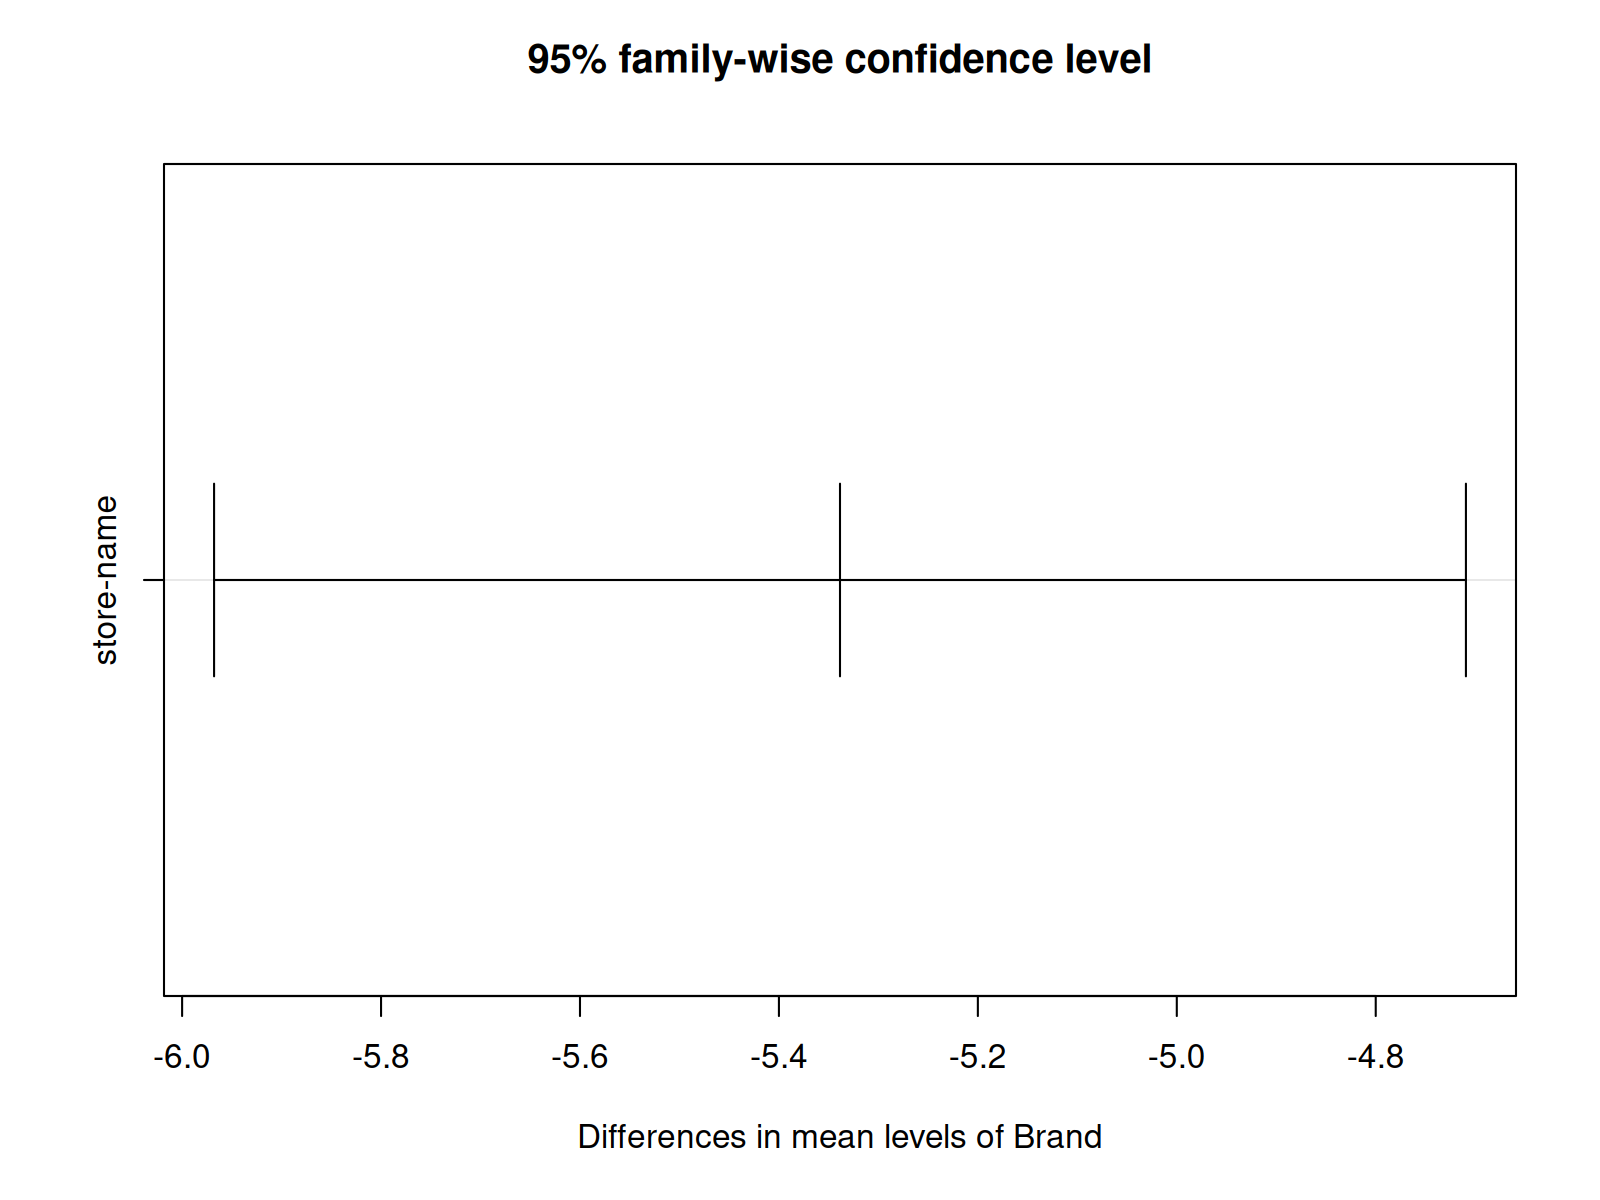

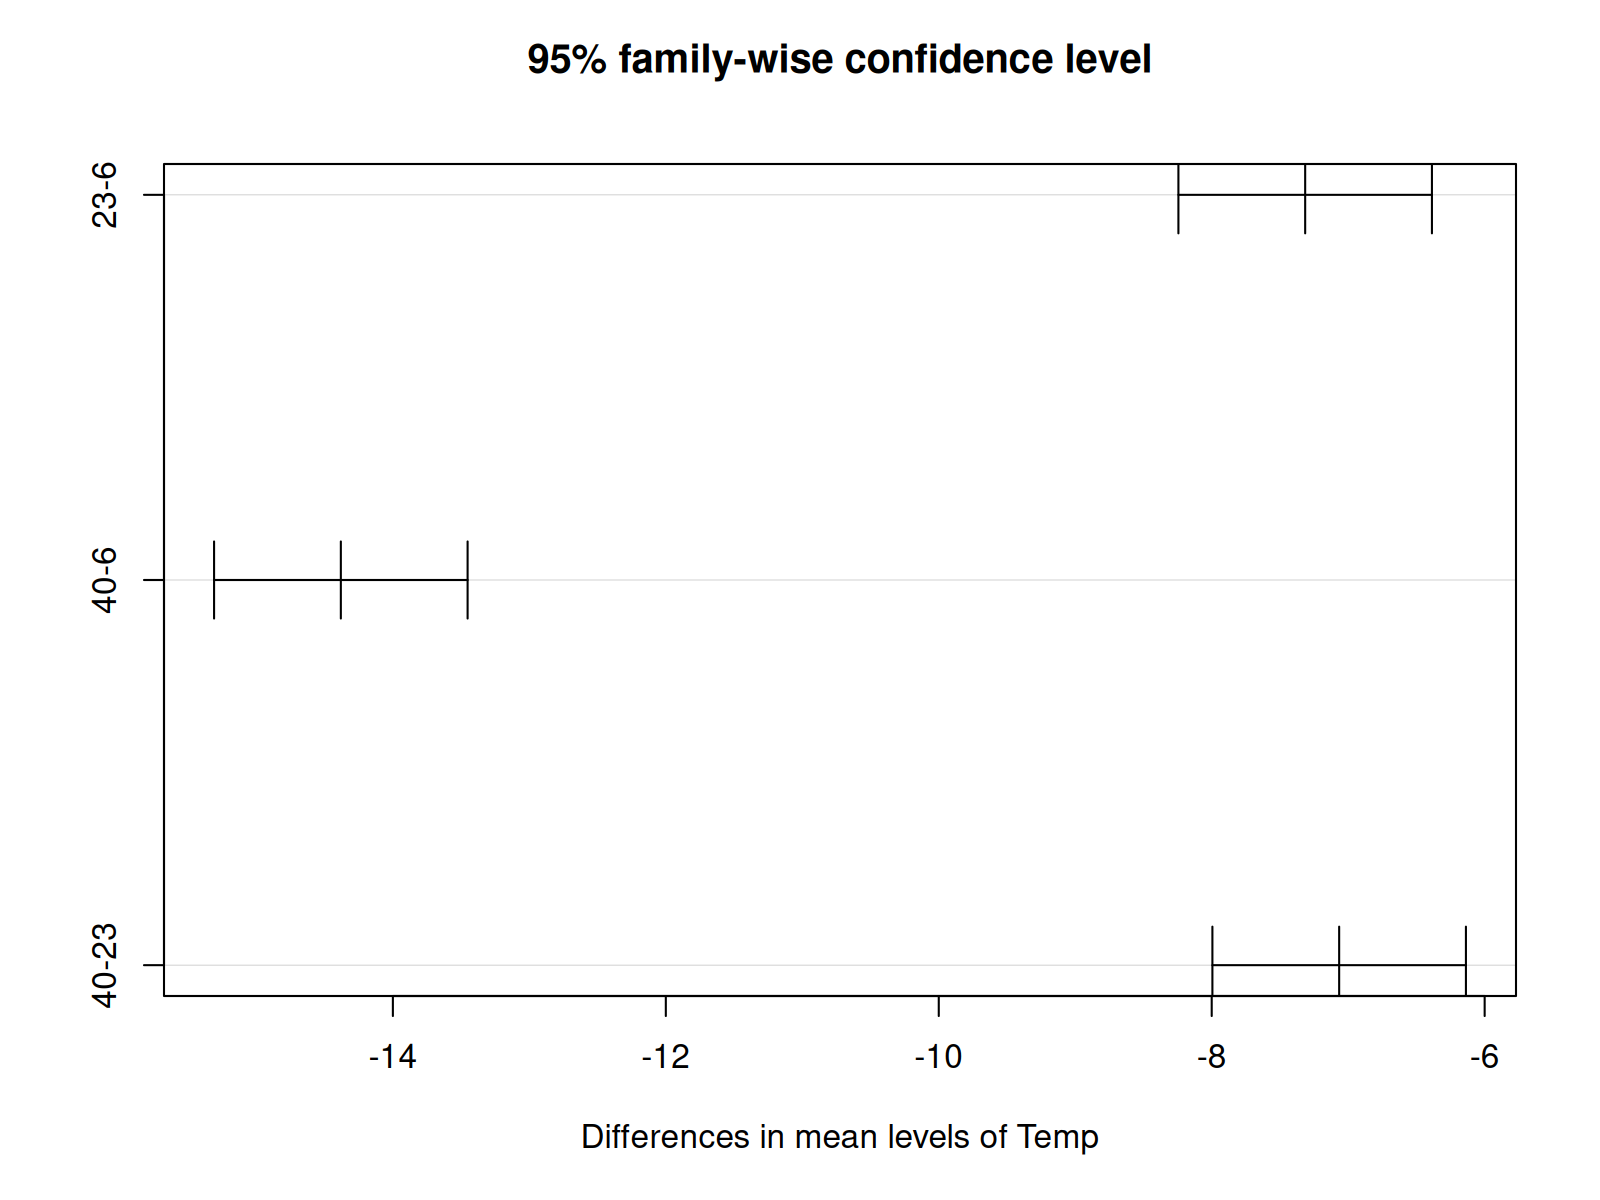

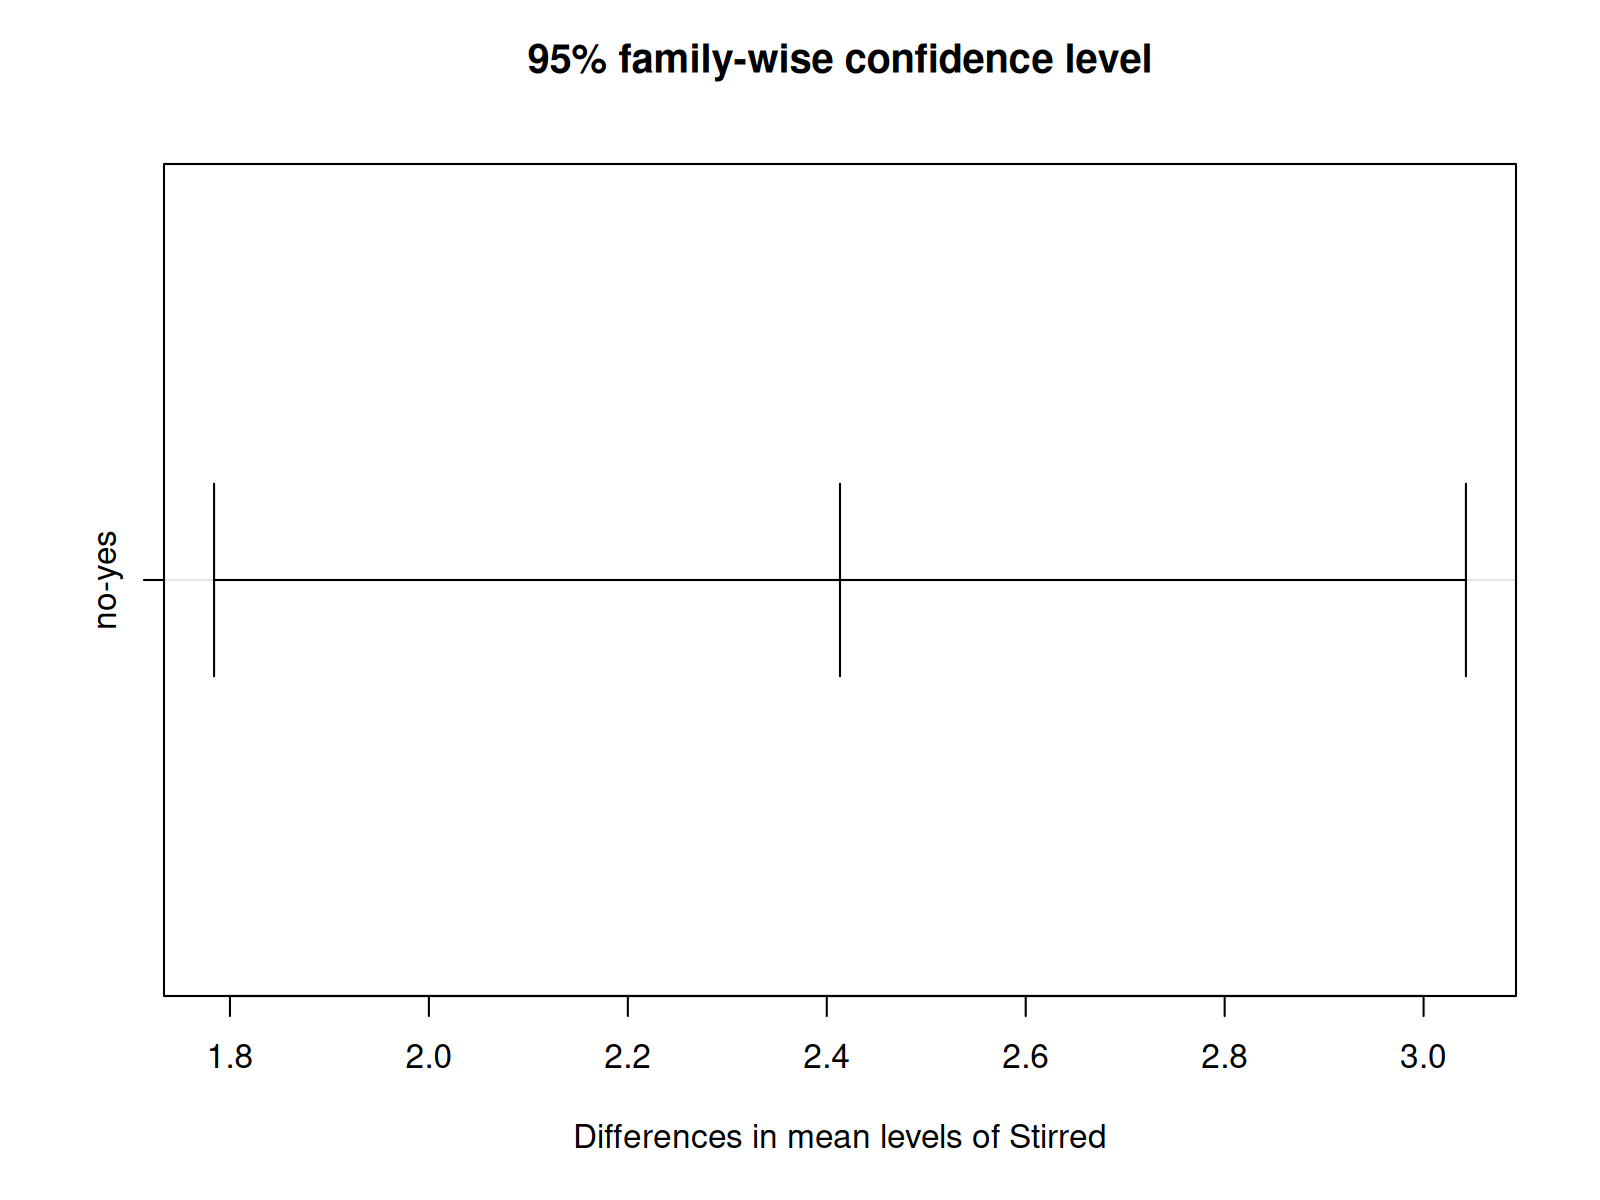

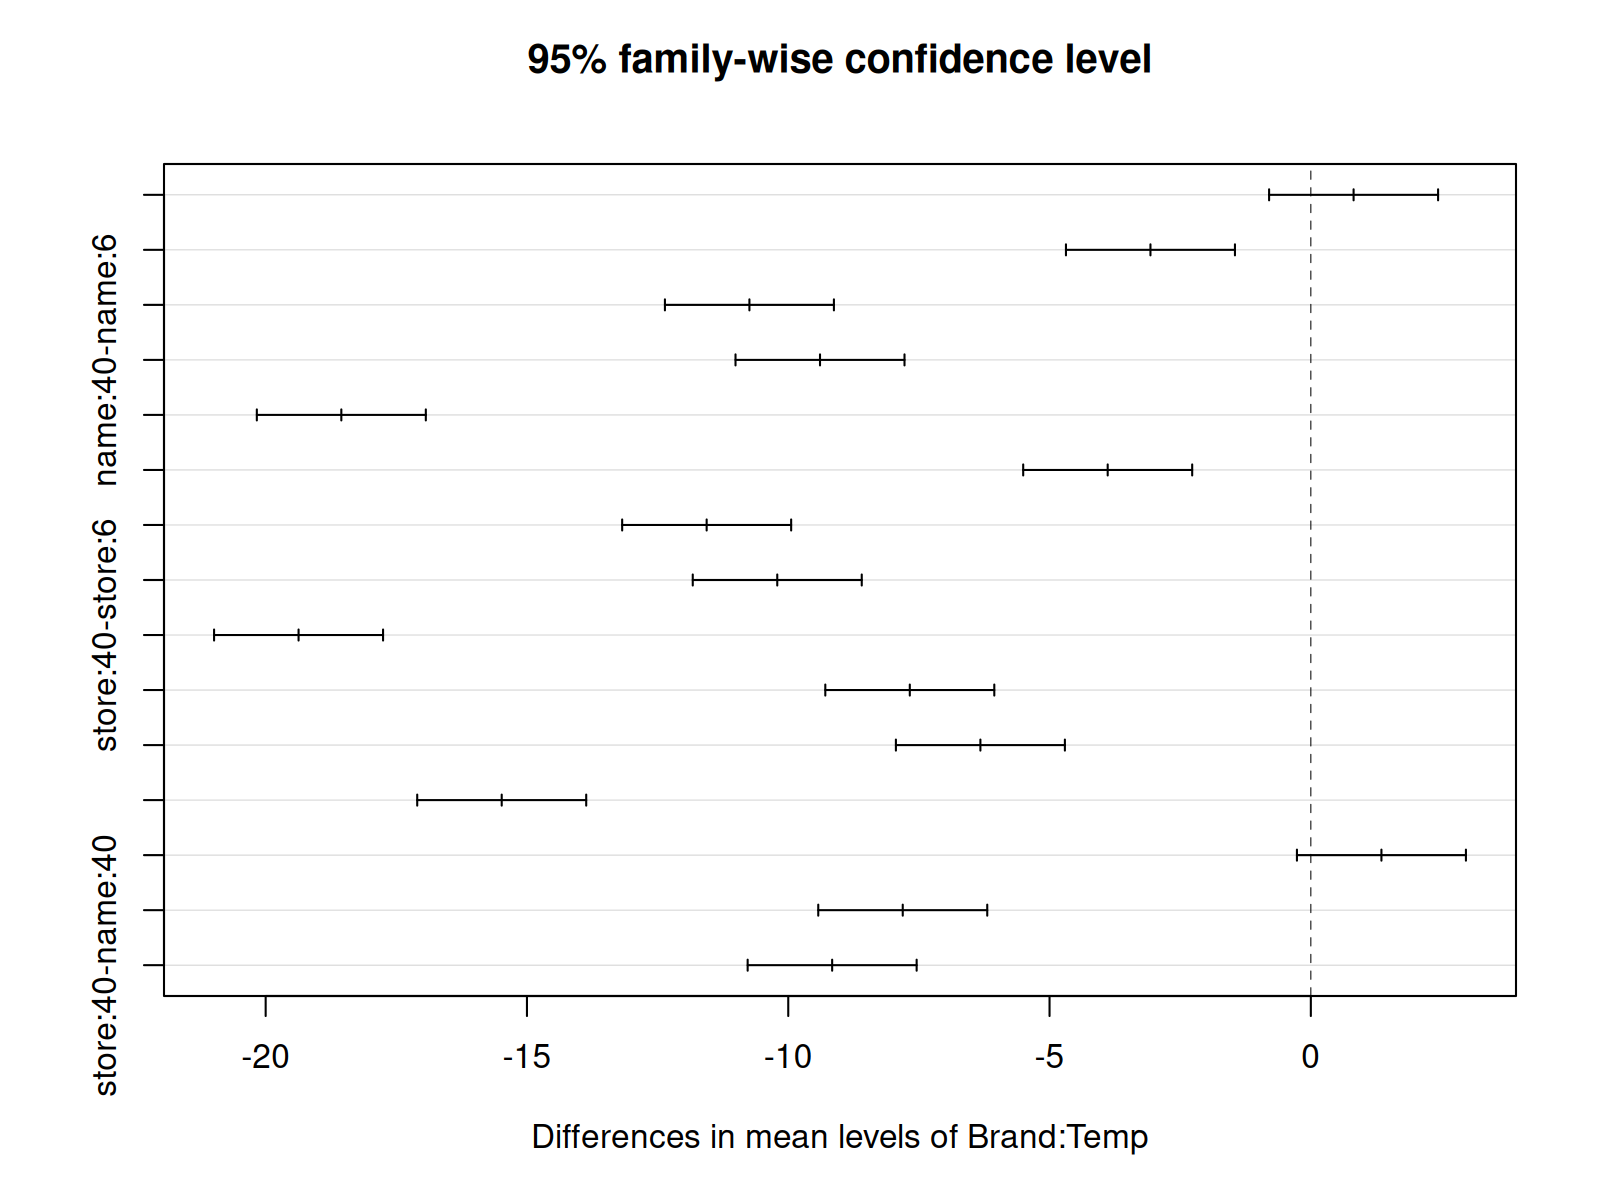

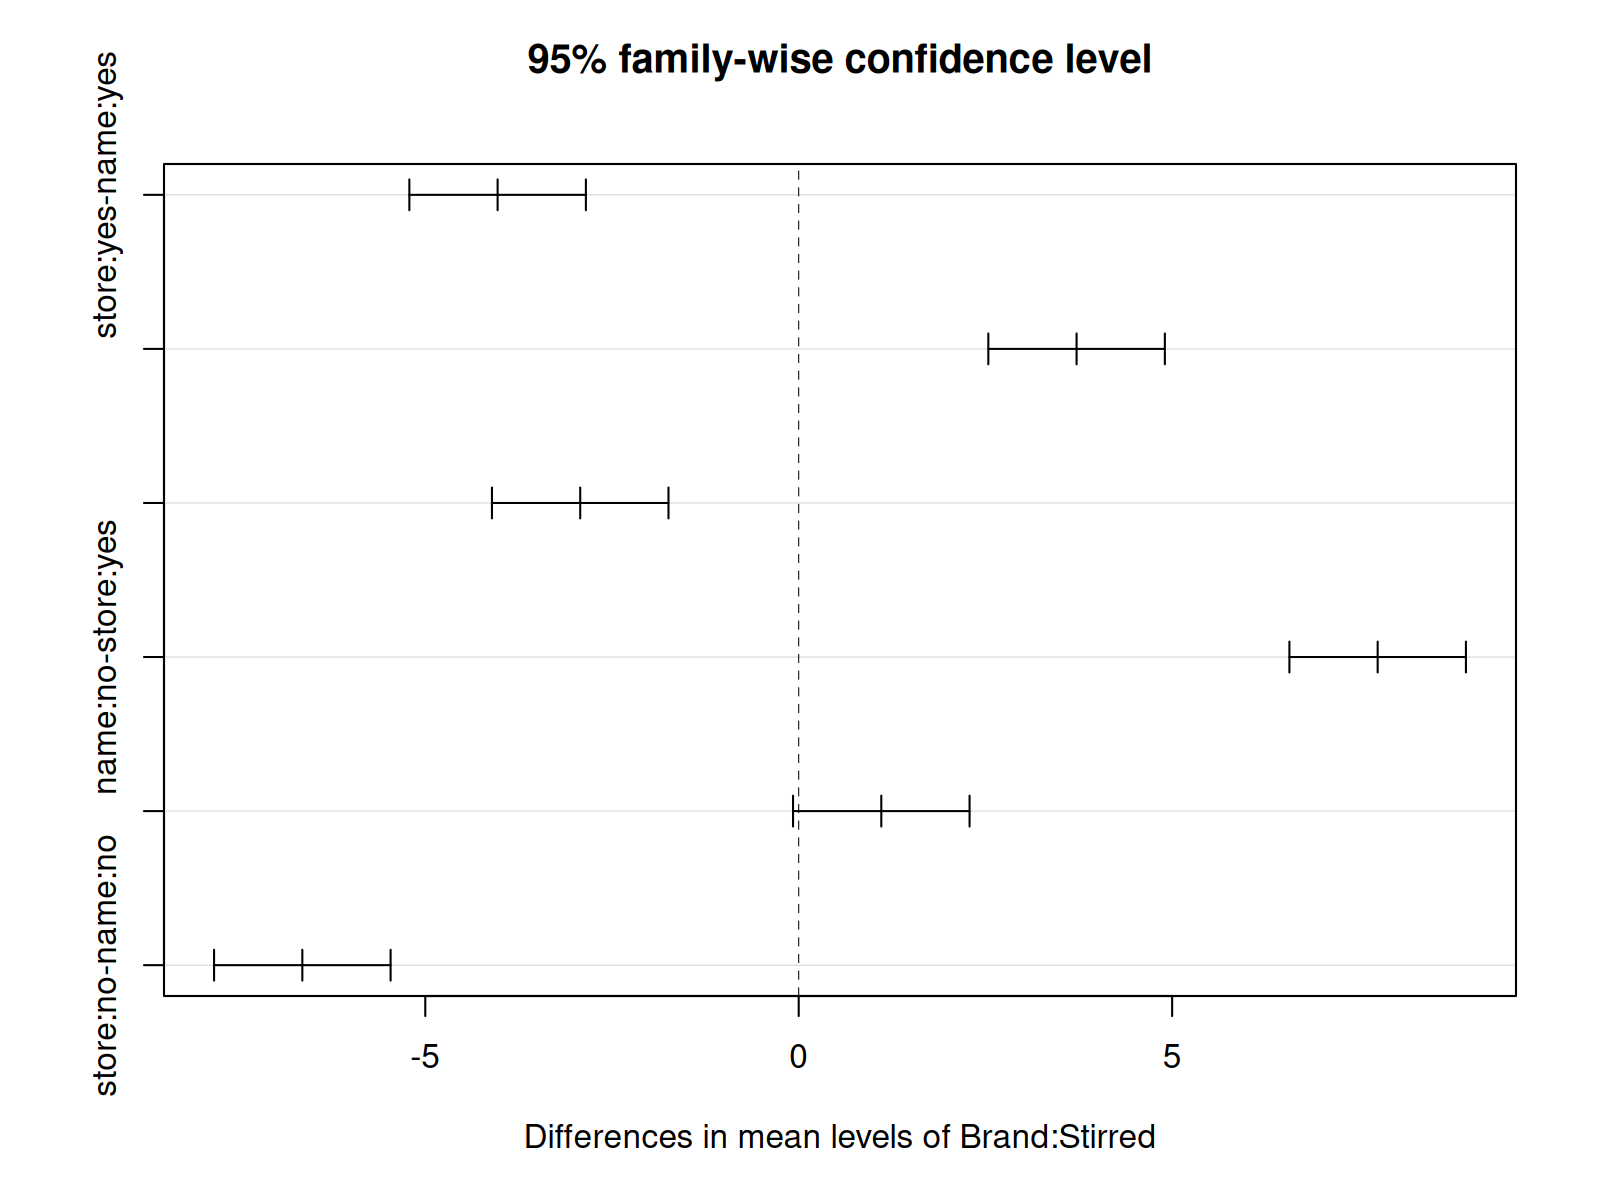

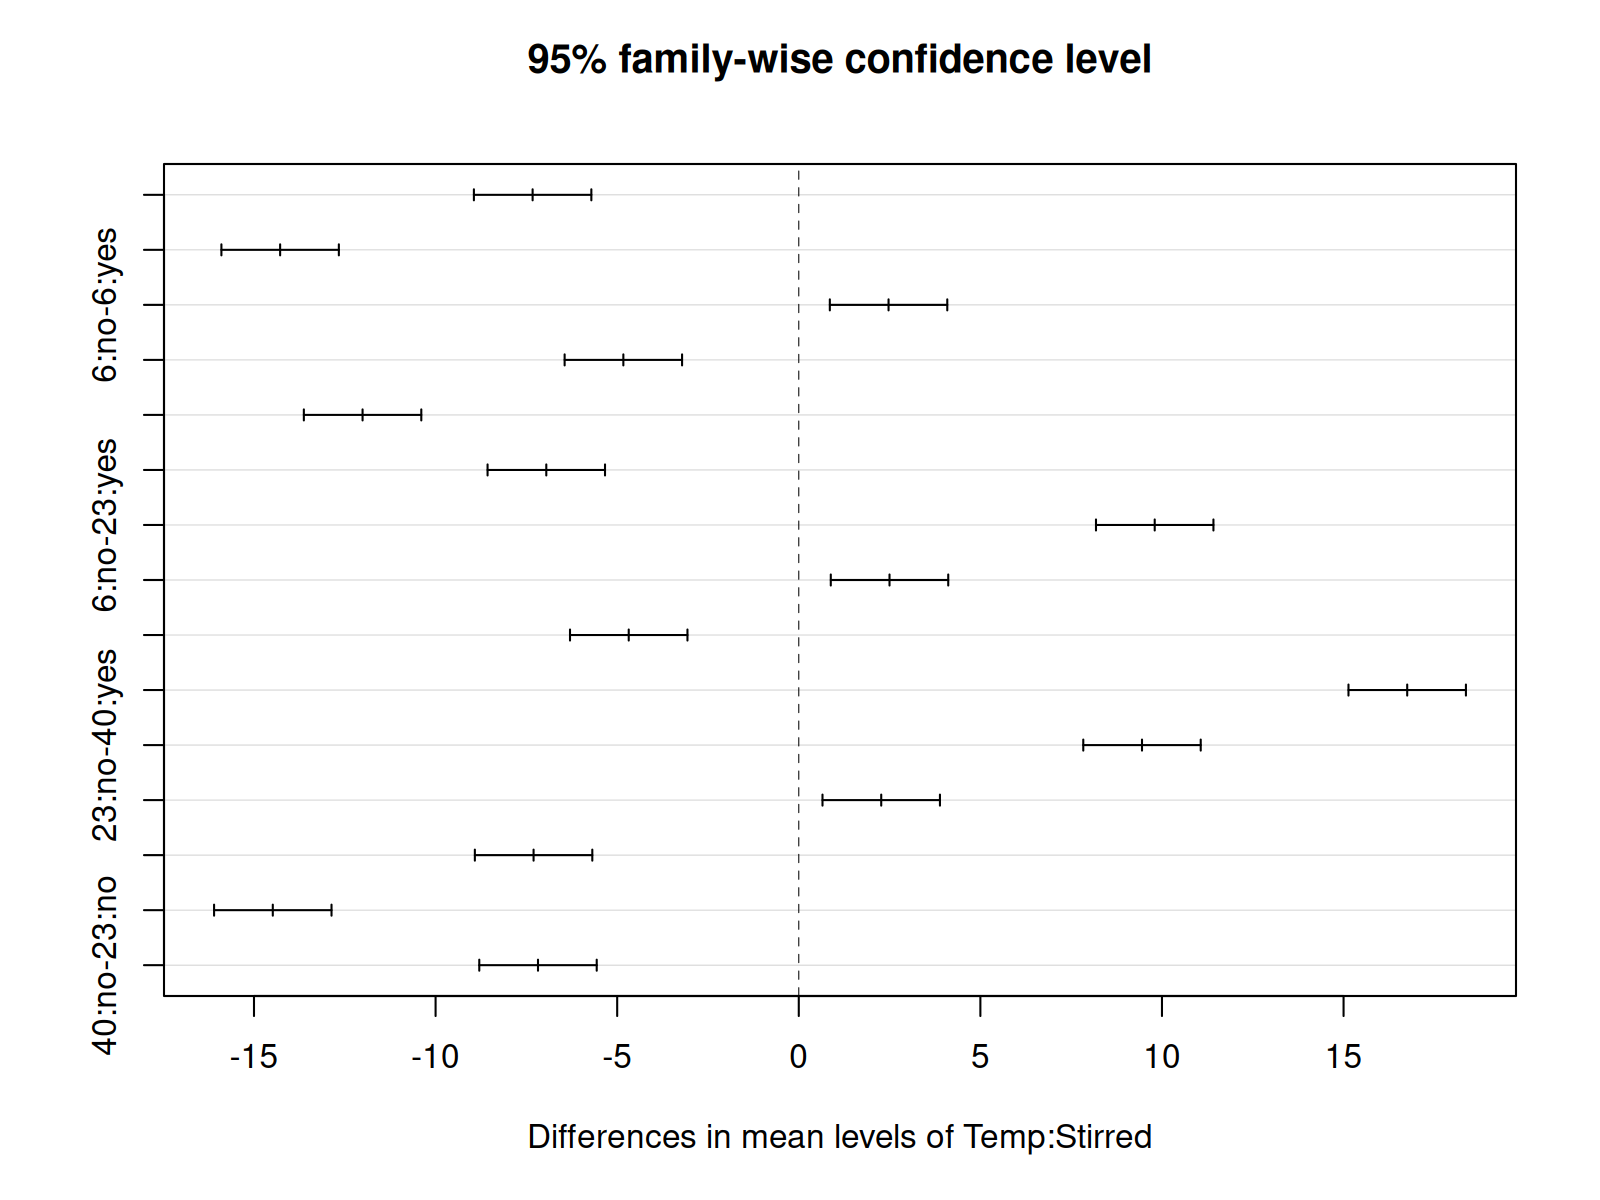

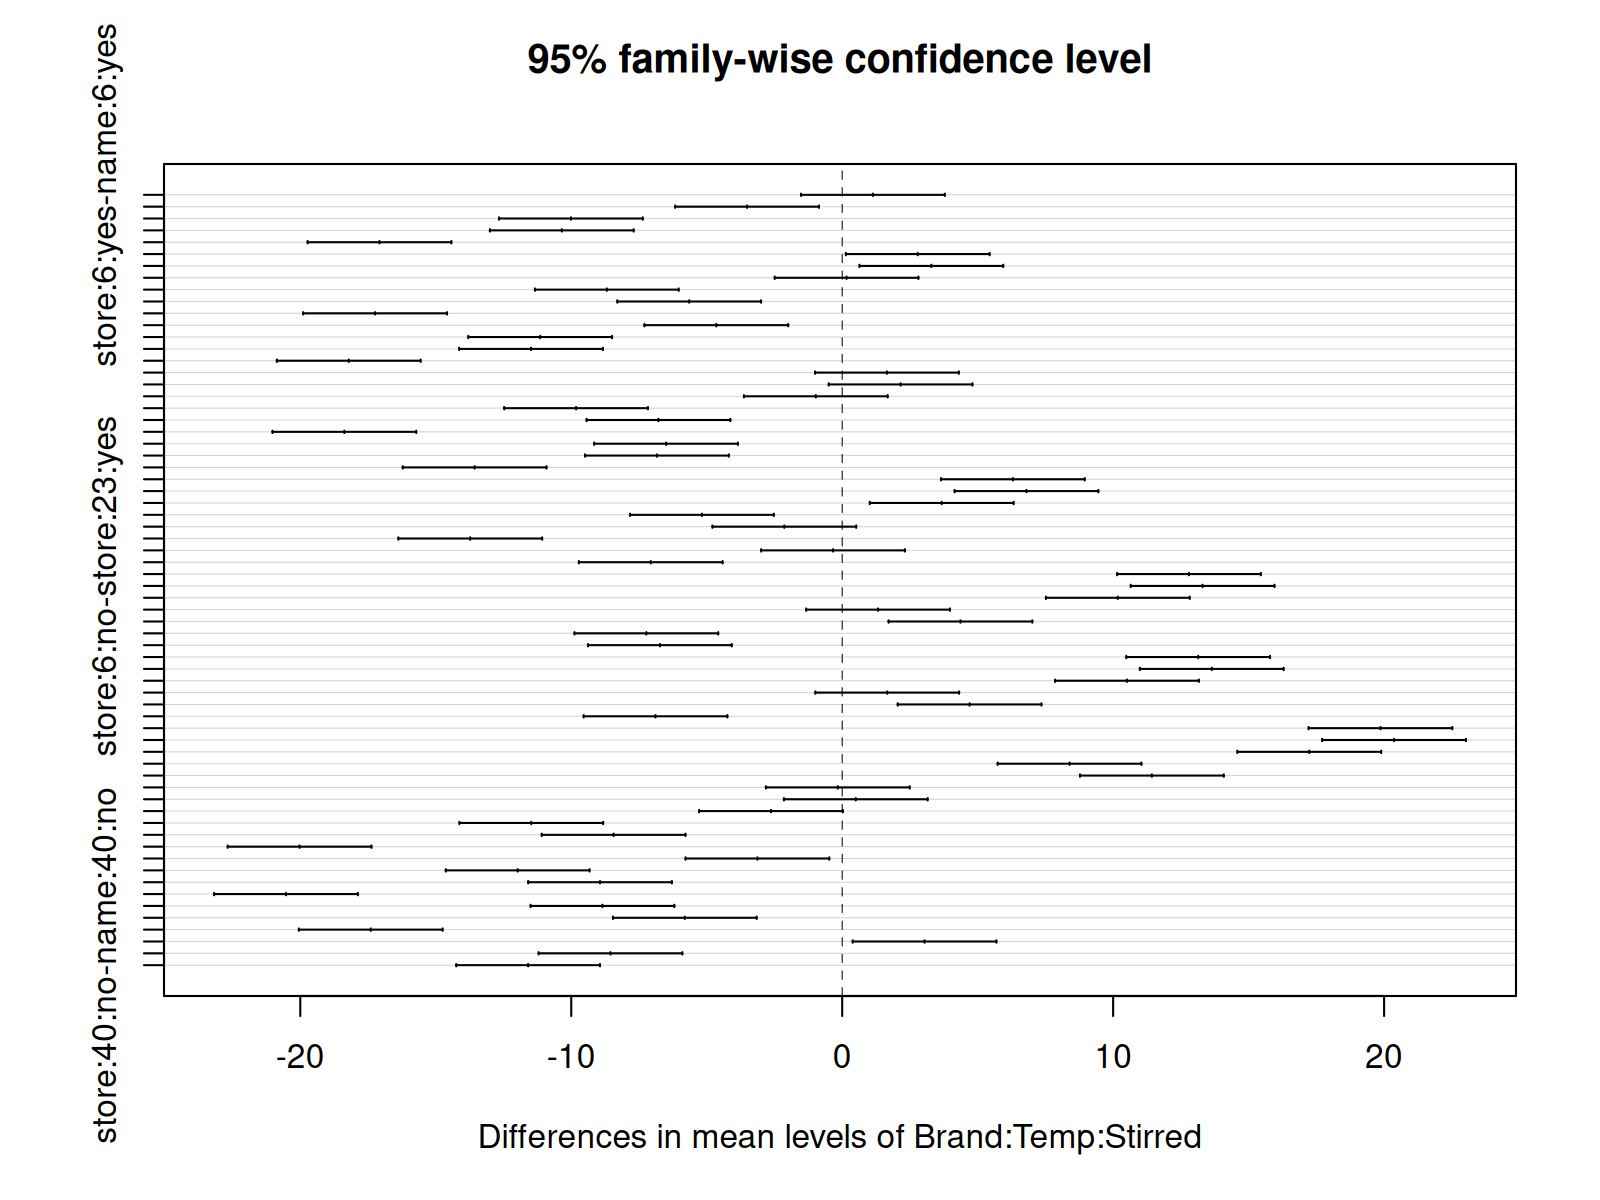

In [20]:
TukeyHSD(aov_eff)
plot(TukeyHSD(aov_eff))

$$
Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_3 + \beta_4 x_1 x_2 x_3
$$

In [ ]:
aov_red <- aov(lm_eff2 <- lm(Time ~ Temp + Stirred + Brand:Temp + Brand:Temp:Stirred, data = df_eff))

In [ ]:
summary(aov_eff)

In [ ]:
anova(lm_eff2, lm_eff)

In [ ]:
summary(lm_eff)
summary(lm_eff2)

In [ ]:
cooksD_values <- cooks.distance(lm_eff)
 
ggplot() + geom_col(aes(y = cooksD_values, x = 1:length(cooksD_values)), width = 0.025, col = 'red')  + 
    geom_point(aes(y = cooksD_values, x = 1:length(cooksD_values))) + xlab('Sample Points') + ylab("Cook's Distance") + 
    geom_hline(yintercept = 0.25, lty = 2)

In [ ]:
df_eff %>% group_by(Brand, Temp, Stirred) %>% 
summarise('25%' = quantile(Time, probs = 0.25),
          'Mean' = mean(Time), 
          'Median' = median(Time),
          '75%' = quantile(Time, probs = 0.75),
          'Var' = var(Time), 
          'n' = n())

In [ ]:
names(summary(lm_eff))

In [ ]:
lm_eff$resid

qqnorm(lm_eff$resid, pch = 20)
qqline(lm_eff$resid, col = "maroon", lwd = 2)

In [ ]:
shapiro.test(lm_eff$resid)

In [ ]:
influenceIndexPlot(lm_eff)

In [ ]:
plot(df_eff)

In [ ]:
df_eff %>% group_by(Brand, Temp) %>% summarise('Values' = list(Time))

In [ ]:
library(lme4)
summary(lmer(Time ~ Brand + (1|Temp) + (1|Brand:Temp), data = df_eff))
################################################################################
summary(aov(Time ~ Brand + Temp + Brand:Temp, data = df_eff))

In [ ]:
summary(aov_eff)

$Model~1: Y_{ijkl} = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha \beta)_{ij} + (\alpha \gamma)_{ik} + (\gamma \beta)_{jk} + (\alpha \beta \gamma)_{ijk} + \epsilon_{ijkl}$  
$Model~2: Y_{ijkl} = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha \beta)_{ij} + \epsilon_{ijkl}$  
$Model~3: Y_{ijkl} = \mu + \alpha_i + \beta_j + \gamma_k + \epsilon_{ijkl}$ 

Where $\alpha$ is brand effect, $\beta$ is temperature effect, $\gamma$ is stir effect. i, j, k are (1, 2), (1,2,3), and (1,2), respectively. $\epsilon_{ijkl}$ is assumed to be normally distributed with a $\mu_\epsilon$ of 0 and a variance of $\sigma^2_\epsilon$. $\mu$ is the overall mean and is an unknown value.

Mixed Effects models:  
$Model~4: Y_{ijk} = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha \beta)_{ij} + \epsilon_{ijk}$  
Where both temperature and brand are random.  
$Model~5: Y_{ijk} = \mu + A_i + \beta_j + \gamma_k + (A \beta)_{ij} + \epsilon_{ijk}$  
Where temperature is fixed and brand is random.  
$Model~6: Y_{ijk} = \mu + \alpha_i + B_j + \gamma_k + (\alpha B)_{ij} + \epsilon_{ijk}$  
Where temperature is random and brand is fixed.

With order as a factor:  
$Model~7: Y_{ijklm} = \mu + \alpha_i + \beta_j + \gamma_k + \nu_l + (\alpha \beta)_{ij} + (\alpha \gamma)_{ik} + (\gamma \beta)_{jk} + (\alpha \beta \gamma)_{ijk} + \epsilon_{ijklm}$  
Similar to model 1, but with an introduced effect, $\nu$ to represent order.

In [ ]:
summary(lm_eff)$adj.r.squared
summary(lm_eff)$r.squared

In [ ]:
aov_block_eff <- aov(lm_block_eff <- lm(Time ~ Brand * Temp + Stirred, data = df_eff))
aov_block_eff_noint <- aov(lm_block_eff <- lm(Time ~ Brand + Temp + Stirred, data = df_eff))
aov_block_order_eff <- aov(lm_block_order_eff <- lm(Time ~ Brand * Temp + Stirred + Order, data = df_eff))
aov_three_order_eff <- aov(lm_three_order_eff <- lm(Time ~ Brand * Temp * Stirred + Order, data = df_eff))

In [ ]:
summary(lm_block_eff)$adj.r.squared
summary(lm_block_eff)$r.squared

In [ ]:
summary(lm_block_order_eff)$adj.r.squared
summary(lm_block_order_eff)$r.squared

In [ ]:
summary(lm_three_order_eff)$adj.r.squared
summary(lm_three_order_eff)$r.squared

In [ ]:
df_aov <- aov_eff

sqrt(sum(df_aov$residuals^2)/36)

In [ ]:
RMSE_function <- function(df_aov){
    
    r_mse <- sqrt(sum(df_aov$residuals^2)/df_aov$df)
    
    r_s <- 1 - tail(summary(df_aov)[1][[1]][[2]], n = 1) / sum(summary(df_aov)[1][[1]][2])

    a_r_s <- 1 - (1 - r_s)*(nrow(df_aov$model) - 1)/(df_aov$df)
    
    aic_ <- AIC(df_aov)
    
    bic_ <- BIC(df_aov)
    
    output_stats <- c(
        r_mse,
        r_s,
        a_r_s,
        aic_,
        bic_
    )
    return(output_stats)
}

print(RMSE_function(aov_eff))
print(RMSE_function(aov_block_eff))
print(RMSE_function(aov_block_eff_noint))
print(RMSE_function(aov_block_order_eff))
print(RMSE_function(aov_three_order_eff))

In [ ]:
knitr::kable(Anova(aov_eff, type=3),'simple', digits = 3)

In [ ]:
aov_reduced <- aov(lm_reduced <- lm(Time ~ Brand + Temp + Stirred + Brand:Temp + Brand:Temp:Stirred, df_eff))
print(RMSE_function(aov_reduced))

In [ ]:
summary(lm_reduced)

In [ ]:
summary(aov_reduced)

In [ ]:
summary(lm_eff)

In [ ]:
max(vif(aov_eff)[,3])
vif(aov_eff)

In [ ]:
dwtest(aov_eff) #Test for independence of errors
#H0: Uncorrelated errors
#Ha: correlation between errors

In [ ]:
bptest(aov_eff) #Test for constant variance
#H0: Equal variance
#HA: Not equal variance

In [ ]:
df_eff %>% group_by(Brand, Temp, Stirred) %>% 
summarise('Min' = min(Time),
          '25%' = quantile(Time, probs = 0.25),
          'Mean' = mean(Time), 
          'Median' = median(Time),
          '75%' = quantile(Time, probs = 0.75),
          'Max' = max(Time),
          'Range' = Max - Min,
          'Var' = var(Time), 
          'n' = n())


In [ ]:
df_eff %>% group_by(Temp) %>% 
summarise('Min' = min(Time),
          '25%' = quantile(Time, probs = 0.25),
          'Mean' = mean(Time), 
          'Median' = median(Time),
          '75%' = quantile(Time, probs = 0.75),
          'Max' = max(Time),
          'Range' = Max - Min,
          'Var' = var(Time), 
          'n' = n())

df_eff %>% group_by(Brand) %>% 
summarise('Min' = min(Time),
          '25%' = quantile(Time, probs = 0.25),
          'Mean' = mean(Time), 
          'Median' = median(Time),
          '75%' = quantile(Time, probs = 0.75),
          'Max' = max(Time),
          'Range' = Max - Min,
          'Var' = var(Time), 
          'n' = n())

df_eff %>% group_by(Stirred) %>% 
summarise('Min' = min(Time),
          '25%' = quantile(Time, probs = 0.25),
          'Mean' = mean(Time), 
          'Median' = median(Time),
          '75%' = quantile(Time, probs = 0.75),
          'Max' = max(Time),
          'Range' = Max - Min,
          'Var' = var(Time), 
          'n' = n())

In [ ]:
library(broom)
glance(aov_eff)

In [ ]:
library(lme4)
summary(lmer(Time ~ Brand + (1|Temp) + (1|Brand:Temp), data = df_eff))

In [ ]:
df_mixed <- summary(aov(Time ~ Brand + Temp + Brand:Temp, data = df_eff))

In [ ]:
df_mixed[[1]]

In [ ]:
MSA <- df_mixed[[1]][1, 3]
MSB <- df_mixed[[1]][2, 3]
MSAB <- df_mixed[[1]][3, 3]
MSE <- df_mixed[[1]][4, 3]

f_scores <- c(fa <- MSA/MSAB, fb <- MSB/MSAB, fab <- MSAB/MSE)

knitr::kable(f_scores, col.names = "F Score")

In [ ]:
library(lmerTest)
lm_mixed <- lmer(Time ~ Brand + (1|Temp) + (1|Brand:Temp), data = df_eff)
ranova(lm_mixed)

In [ ]:
mixed_smry <- summary(lm_mixed)
df_mixed <- summary(aov(Time ~ Brand + Temp + Brand:Temp, data = df_eff))

In [ ]:
for (i in names(mixed_smry)){
    print(mixed_smry[i])
}

In [ ]:
mixed_smry$call

In [ ]:
mixed_ll <- mixed_smry$logLik[1]

In [ ]:
knitr::kable(cbind(f_scores, 1:3))

In [ ]:
df_mixed

In [ ]:
anova(lm(Time ~ Brand + Temp + Brand:Temp, data = df_eff))

In [ ]:
mixed_smry